# IF3070 Foundations of Artificial Intelligence | Tugas Besar 2

This notebook serves as a template for the assignment. Please create a copy of this notebook to complete your work. You can add more code blocks, markdown blocks, or new sections if needed.


Group Number: 08

Group Members:
- Daffari Adiyatma (18222003)
- Aththariq Lisan Q. D. S. (18222013)
- Muhammad Rafly (18222067)
- Alvin Fadhilah Akmal (18222079)

## Import Libraries

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

## Import Dataset

In [30]:
if 'df_original' not in globals():
    df_original = pd.read_csv('https://drive.google.com/uc?id=1w8DnxXGwaF1dLKlMxmXWVQFOH4vcvfTp')

df = df_original.copy()
df.head()

,id,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,1,NaN,https://www.northcm.ac.th,24.0,www.northcm.ac.th,17.0,0.0,NaN,0.800000,NaN,...,0.0,0.0,1.0,NaN,3.0,NaN,69.0,NaN,NaN,1
1,4,8135291.txt,http://uqr.to/1il1z,NaN,NaN,NaN,NaN,to,1.000000,0.000896,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0
2,5,586561.txt,https://www.woolworthsrewards.com.au,35.0,www.woolworthsrewards.com.au,28.0,0.0,au,0.857143,NaN,...,1.0,0.0,1.0,33.0,7.0,8.0,15.0,NaN,2.0,1
3,6,NaN,NaN,31.0,NaN,NaN,NaN,com,0.562500,0.522907,...,1.0,0.0,1.0,24.0,5.0,14.0,NaN,NaN,NaN,1
4,11,412632.txt,NaN,NaN,www.nyprowrestling.com,22.0,0.0,NaN,1.000000,NaN,...,0.0,0.0,1.0,NaN,NaN,14.0,NaN,0.0,NaN,1


In [31]:
#Drop kolom yang tidak digunakan
df = df.drop(columns=['FILENAME'])

In [32]:
df_sample = df.sample(frac=0.2, random_state=42)
df_sample.shape

(28081, 55)

# 1. Split Training Set and Validation Set

Splitting the training and validation set works as an early diagnostic towards the performance of the model we train. This is done before the preprocessing steps to **avoid data leakage inbetween the sets**. If you want to use k-fold cross-validation, split the data later and do the cleaning and preprocessing separately for each split.

Note: For training, you should use the data contained in the `train` folder given by the TA. The `test` data is only used for kaggle submission.

In [33]:
train_set, val_set = train_test_split(df_sample, test_size=0.2, random_state=42, shuffle=True)

print(f"Ukuran training set: {len(train_set)}")
print(f"Ukuran validation set: {len(val_set)}")

Ukuran training set: 22464
Ukuran validation set: 5617


# 2. Data Cleaning and Preprocessing

This step is the first thing to be done once a Data Scientist have grasped a general knowledge of the data. Raw data is **seldom ready for training**, therefore steps need to be taken to clean and format the data for the Machine Learning model to interpret.

By performing data cleaning and preprocessing, you ensure that your dataset is ready for model training, leading to more accurate and reliable machine learning results. These steps are essential for transforming raw data into a format that machine learning algorithms can effectively learn from and make predictions.

We will give some common methods for you to try, but you only have to **at least implement one method for each process**. For each step that you will do, **please explain the reason why did you do that process. Write it in a markdown cell under the code cell you wrote.**

## A. Data Cleaning

**Data cleaning** is the crucial first step in preparing your dataset for machine learning. Raw data collected from various sources is often messy and may contain errors, missing values, and inconsistencies. Data cleaning involves the following steps:

1. **Handling Missing Data:** Identify and address missing values in the dataset. This can include imputing missing values, removing rows or columns with excessive missing data, or using more advanced techniques like interpolation.

2. **Dealing with Outliers:** Identify and handle outliers, which are data points significantly different from the rest of the dataset. Outliers can be removed or transformed to improve model performance.

3. **Data Validation:** Check for data integrity and consistency. Ensure that data types are correct, categorical variables have consistent labels, and numerical values fall within expected ranges.

4. **Removing Duplicates:** Identify and remove duplicate rows, as they can skew the model's training process and evaluation metrics.

5. **Feature Engineering**: Create new features or modify existing ones to extract relevant information. This step can involve scaling, normalizing, or encoding features for better model interpretability.

### I. Remove Duplicates
Handling duplicate values is crucial because they can compromise data integrity, leading to inaccurate analysis and insights. Duplicate entries can bias machine learning models, causing overfitting and reducing their ability to generalize to new data. They also inflate the dataset size unnecessarily, increasing computational costs and processing times. Additionally, duplicates can distort statistical measures and lead to inconsistencies, ultimately affecting the reliability of data-driven decisions and reporting. Ensuring data quality by removing duplicates is essential for accurate, efficient, and consistent analysis.

In [34]:
train_duplicates = train_set.duplicated().sum()
print(f"Jumlah duplikasi pada train_set: {train_duplicates}")

val_duplicates = val_set.duplicated().sum()
print(f"Jumlah duplikasi pada val_set: {val_duplicates}")

Jumlah duplikasi pada train_set: 0
Jumlah duplikasi pada val_set: 0


Tidak ada duplikasi sehingga proses cukup sampai dipengecekkan. Remove duplikasi dipindahkan ke urutan teratas karena mudah untuk mengecekknya.

### II. Handling Missing Data

Missing data can adversely affect the performance and accuracy of machine learning models. There are several strategies to handle missing data in machine learning:

1. **Data Imputation:**

    a. **Mean, Median, or Mode Imputation:** For numerical features, you can replace missing values with the mean, median, or mode of the non-missing values in the same feature. This method is simple and often effective when data is missing at random.

    b. **Constant Value Imputation:** You can replace missing values with a predefined constant value (e.g., 0) if it makes sense for your dataset and problem.

    c. **Imputation Using Predictive Models:** More advanced techniques involve using predictive models to estimate missing values. For example, you can train a regression model to predict missing numerical values or a classification model to predict missing categorical values.

2. **Deletion of Missing Data:**

    a. **Listwise Deletion:** In cases where the amount of missing data is relatively small, you can simply remove rows with missing values from your dataset. However, this approach can lead to a loss of valuable information.

    b. **Column (Feature) Deletion:** If a feature has a large number of missing values and is not critical for your analysis, you can consider removing that feature altogether.

3. **Domain-Specific Strategies:**

    a. **Domain Knowledge:** In some cases, domain knowledge can guide the imputation process. For example, if you know that missing values are related to a specific condition, you can impute them accordingly.

4. **Imputation Libraries:**

    a. **Scikit-Learn:** Scikit-Learn provides a `SimpleImputer` class that can handle basic imputation strategies like mean, median, and mode imputation.

    b. **Fancyimpute:** Fancyimpute is a Python library that offers more advanced imputation techniques, including matrix factorization, k-nearest neighbors, and deep learning-based methods.

The choice of imputation method should be guided by the nature of your data, the amount of missing data, the problem you are trying to solve, and the assumptions you are willing to make.

In [35]:
#Memeriksa Missing Value
missing_count = train_set.isnull().sum()

missing_percentage = (missing_count / len(train_set)) * 100

missing_data = pd.DataFrame({
    'Missing Count': missing_count,
    'Percentage': missing_percentage
})

missing_data_sorted = missing_data.sort_values(by='Missing Count', ascending=False)

print(missing_data_sorted[missing_data_sorted['Missing Count'] > 0])


                            Missing Count  Percentage
Domain                              11263   50.137999
LineOfCode                          11105   49.434651
NoOfExternalRef                     11098   49.403490
HasSocialNet                        10871   48.392984
NoOfCSS                             10868   48.379630
LargestLineLength                   10798   48.068020
HasCopyrightInfo                    10756   47.881054
NoOfURLRedirect                     10710   47.676282
NoOfObfuscatedChar                  10617   47.262286
HasObfuscation                      10605   47.208868
NoOfSelfRedirect                    10560   47.008547
HasPasswordField                    10550   46.964031
LetterRatioInURL                    10470   46.607906
ObfuscationRatio                    10316   45.922365
NoOfLettersInURL                    10184   45.334758
SpacialCharRatioInURL               10056   44.764957
HasSubmitButton                     10003   44.529024
NoOfEqualsInURL             

In [36]:
#Drop Kolom yang missing valuenya di atas 49%
columns_to_drop = ['LineOfCode', 'NoOfExternalRef', 'Domain']

train_set.drop(columns=columns_to_drop, axis=1, inplace=True)
val_set.drop(columns=columns_to_drop, axis=1, inplace=True)

print("Columns dropped:", columns_to_drop)

Columns dropped: ['LineOfCode', 'NoOfExternalRef', 'Domain']


In [37]:
#Buat Imputasi Nanti
# Identifikasi kolom numerik
numerical_columns = train_set.select_dtypes(include=['float64', 'int64']).columns

# Identifikasi kolom biner
binary_columns = [col for col in numerical_columns if set(train_set[col].dropna().unique()) <= {0, 1}]

# Identifikasi kolom non-biner
non_binary_columns = [col for col in numerical_columns if col not in binary_columns]

# Hitung skewness untuk kolom numerik
skewness = train_set[numerical_columns].skew()
print(skewness)

# Klasifikasiin kolom berdasarkan skewness
mean_imputation_columns = skewness[skewness.abs() < 0.5].index.tolist()
median_imputation_columns = skewness[skewness.abs() >= 0.5].index.tolist()

print("Kolom dengan imputasi mean:", mean_imputation_columns)
print("Kolom dengan imputasi median:", median_imputation_columns)

# Imputasi untuk kolom biner
binary_imputer = SimpleImputer(strategy='most_frequent')
train_set[binary_columns] = binary_imputer.fit_transform(train_set[binary_columns])

# Imputasi mean untuk kolom dengan skewness rendah
mean_imputer = SimpleImputer(strategy='mean')
train_set[mean_imputation_columns] = mean_imputer.fit_transform(train_set[mean_imputation_columns])

# Imputasi median untuk kolom dengan skewness tinggi
median_imputer = SimpleImputer(strategy='median')
train_set[median_imputation_columns] = median_imputer.fit_transform(train_set[median_imputation_columns])

# Terapkan transformasi ke validation set menggunakan parameter dari train set
val_set[binary_columns] = binary_imputer.transform(val_set[binary_columns])
val_set[mean_imputation_columns] = mean_imputer.transform(val_set[mean_imputation_columns])
val_set[median_imputation_columns] = median_imputer.transform(val_set[median_imputation_columns])

id                             0.018540
URLLength                     19.240912
DomainLength                   2.232416
IsDomainIP                    34.735267
CharContinuationRate          -1.868861
TLDLegitimateProb             -0.008832
URLCharProb                   -1.126614
TLDLength                      1.166330
NoOfSubDomain                  2.427529
HasObfuscation                76.993505
NoOfObfuscatedChar            97.010506
ObfuscationRatio              88.183668
NoOfLettersInURL              12.652962
LetterRatioInURL              -0.178709
NoOfDegitsInURL               19.790292
DegitRatioInURL                7.018228
NoOfEqualsInURL               26.882872
NoOfQMarkInURL                19.647779
NoOfAmpersandInURL            72.861186
NoOfOtherSpecialCharsInURL    10.172001
SpacialCharRatioInURL          1.758356
IsHTTPS                       -4.800497
LargestLineLength             21.634068
HasTitle                      -6.001295
DomainTitleMatchScore         -0.906902


In [38]:
#Drop kolom kategorikal karena tidak akan diimputasi
categorical_columns = train_set.select_dtypes(include=['object']).columns

train_set.drop(columns=categorical_columns, axis=1, inplace=True)
val_set.drop(columns=categorical_columns, axis=1, inplace=True)

print("Columns dropped (categorical):", categorical_columns.tolist())

Columns dropped (categorical): ['URL', 'TLD', 'Title']


In [39]:
#Cek missing value lagi setelah imputasi
missing_train = train_set.isnull().sum()
missing_train_percentage = (missing_train / len(train_set)) * 100

print("Missing values di Train Set setelah imputasi:")
print(pd.DataFrame({
    'Missing Count': missing_train[missing_train > 0],
    'Percentage': missing_train_percentage[missing_train > 0]
}))

missing_val = val_set.isnull().sum()
missing_val_percentage = (missing_val / len(val_set)) * 100

print("\nMissing values di Validation Set setelah imputasi:")
print(pd.DataFrame({
    'Missing Count': missing_val[missing_val > 0],
    'Percentage': missing_val_percentage[missing_val > 0]
}))
print("Total missing values di Train Set:", train_set.isnull().sum().sum())
print("Total missing values di Validation Set:", val_set.isnull().sum().sum())


Missing values di Train Set setelah imputasi:
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []

Missing values di Validation Set setelah imputasi:
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []
Total missing values di Train Set: 0
Total missing values di Validation Set: 0


### III. Dealing with Outliers

Outliers are data points that significantly differ from the majority of the data. They can be unusually high or low values that do not fit the pattern of the rest of the dataset. Outliers can significantly impact model performance, so it is important to handle them properly.

Some methods to handle outliers:
1. **Imputation**: Replace with mean, median, or a boundary value.
2. **Clipping**: Cap values to upper and lower limits.
3. **Transformation**: Use log, square root, or power transformations to reduce their influence.
4. **Model-Based**: Use algorithms robust to outliers (e.g., tree-based models, Huber regression).

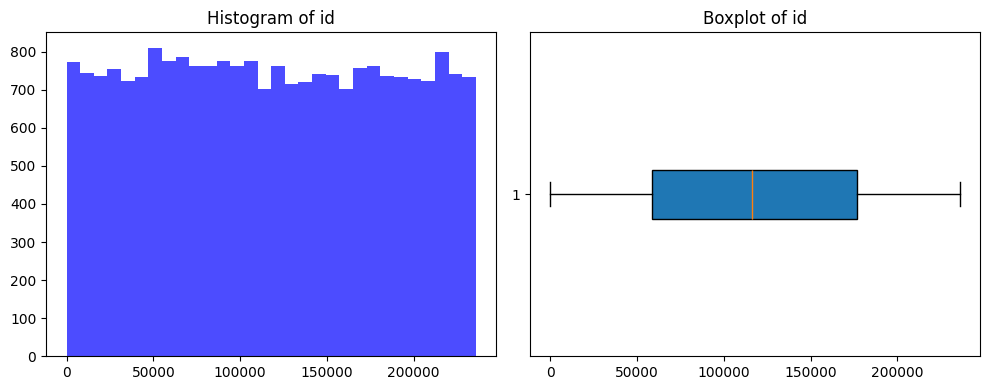

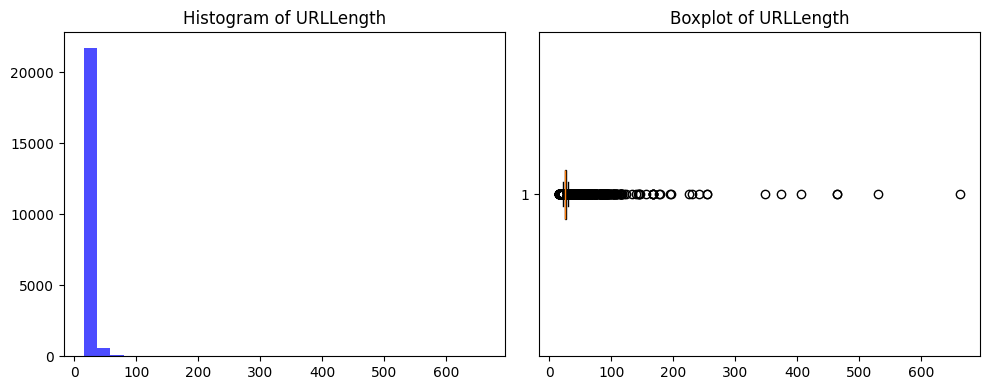

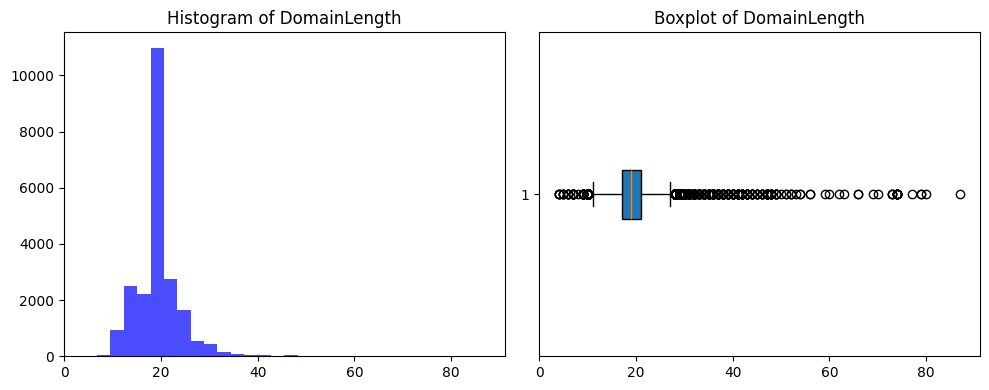

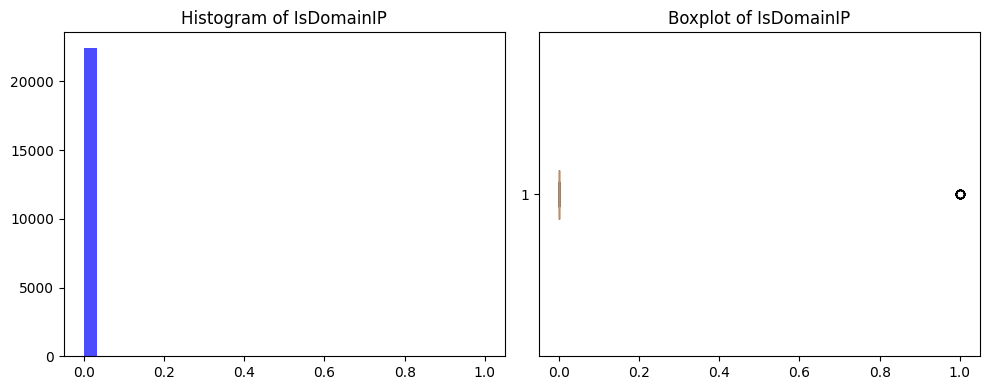

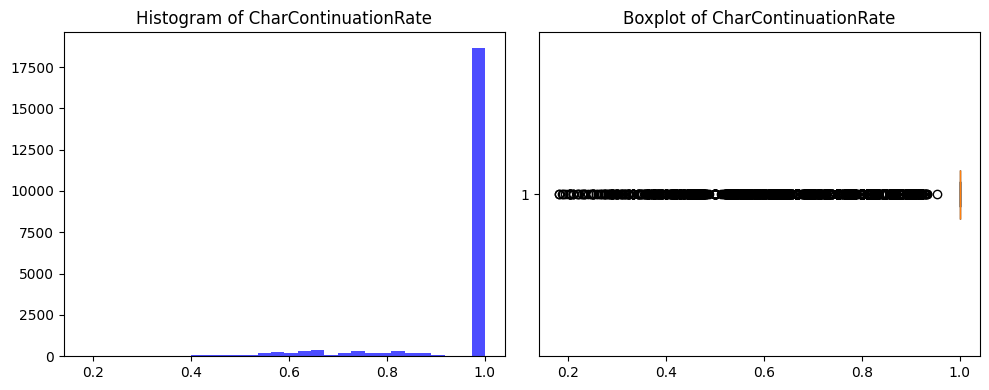

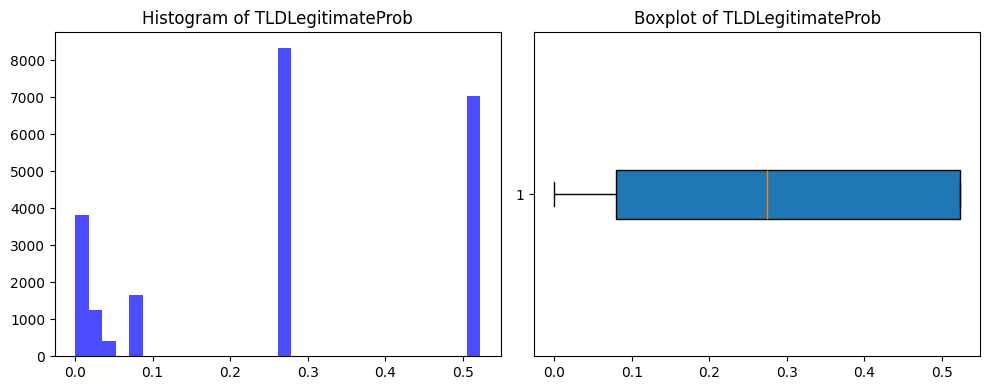

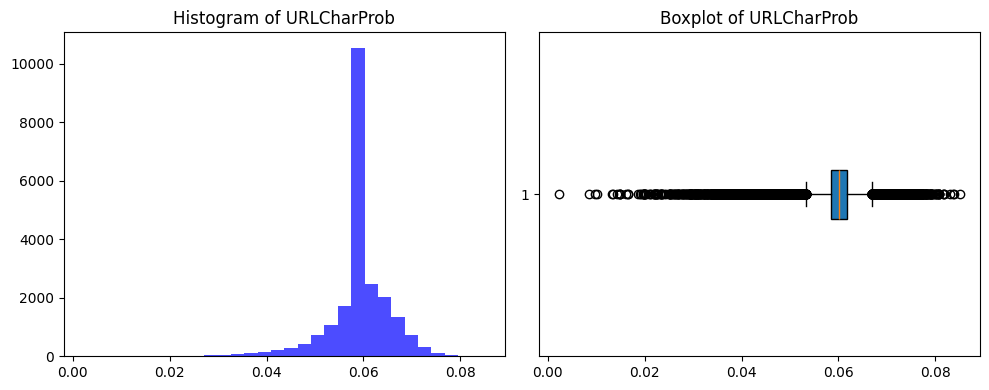

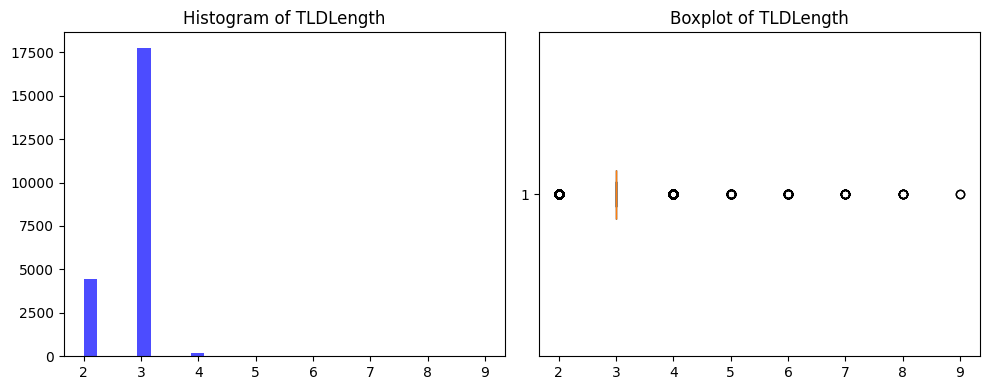

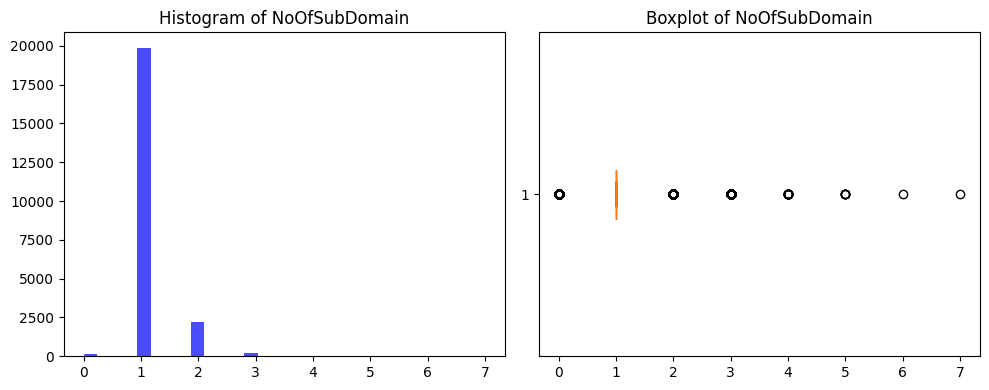

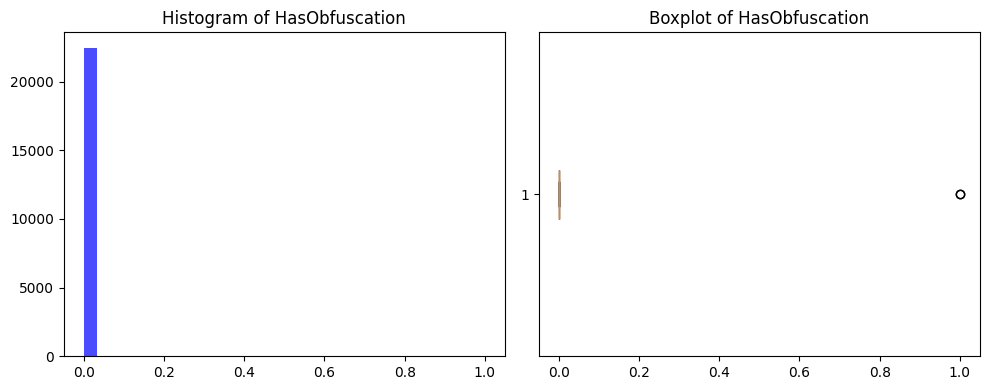

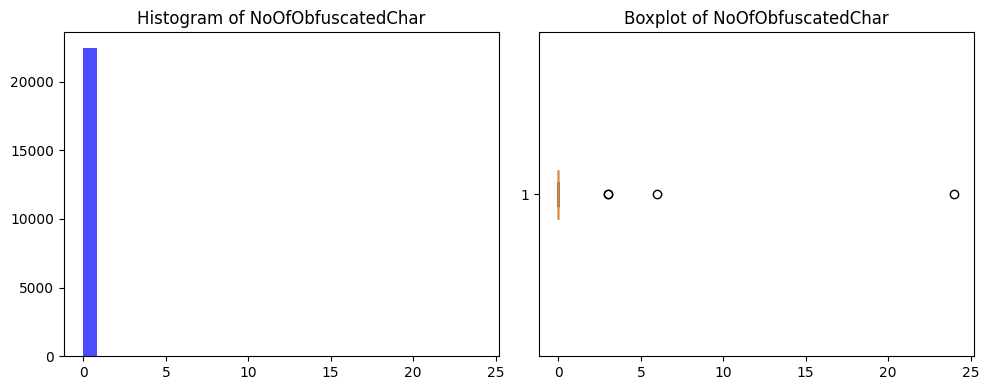

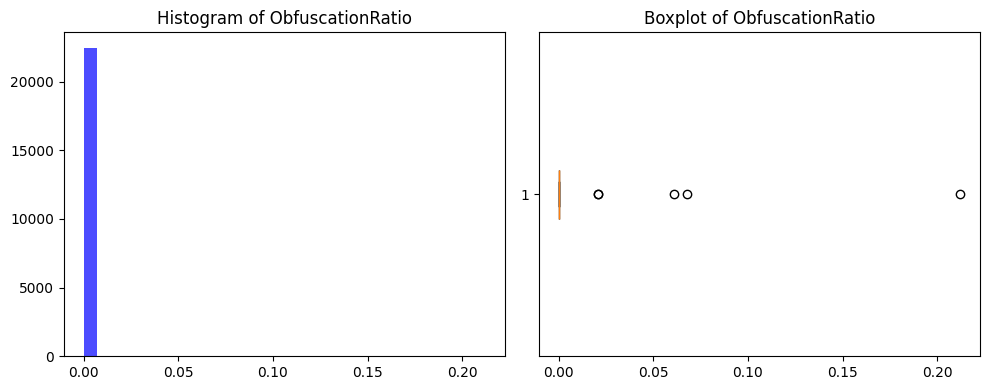

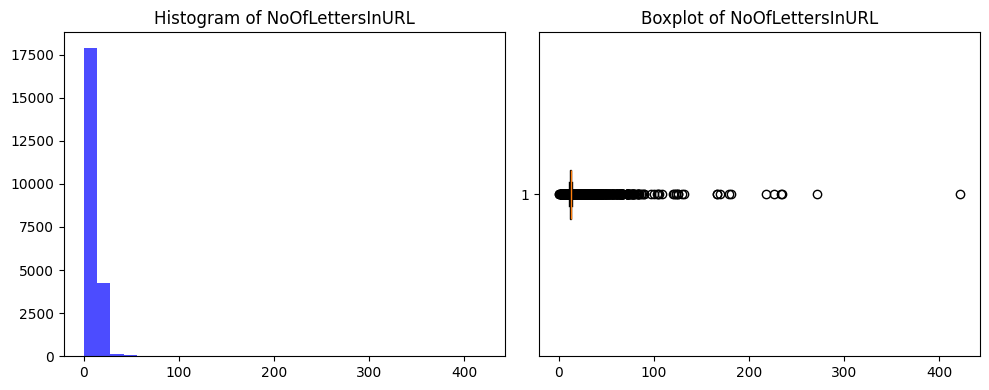

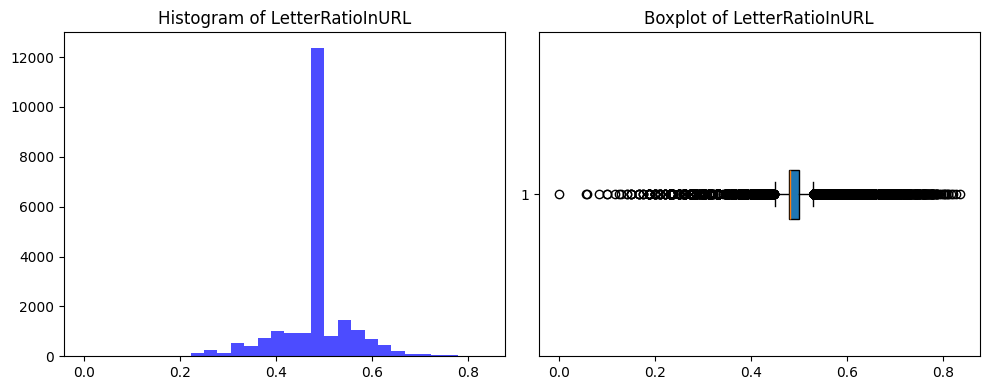

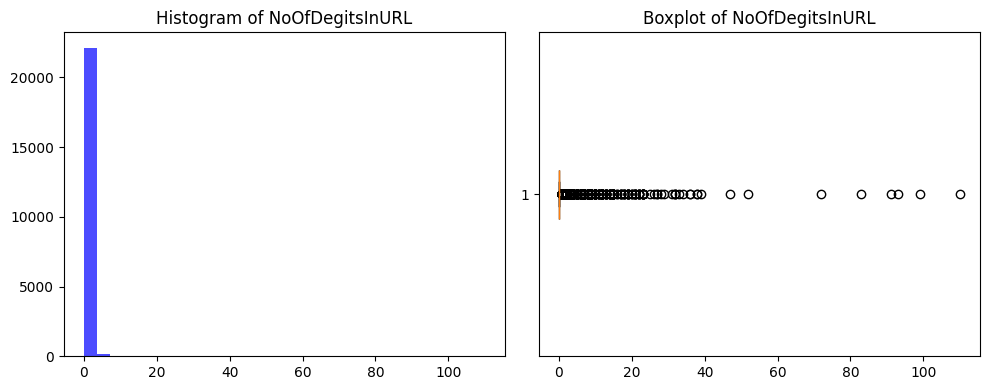

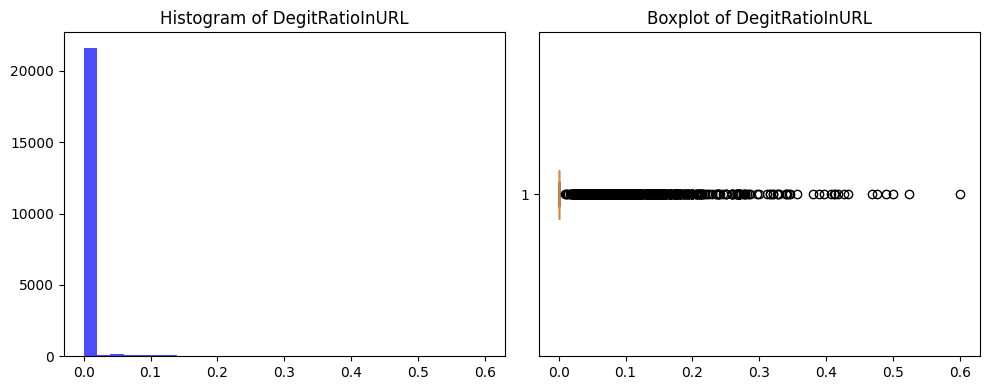

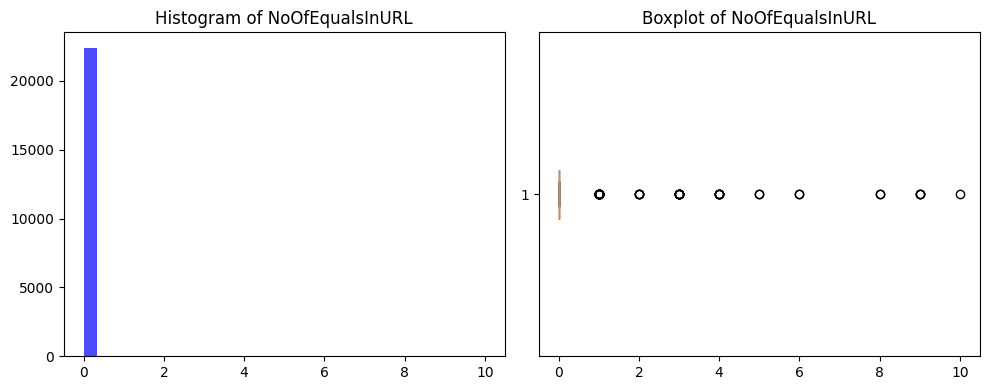

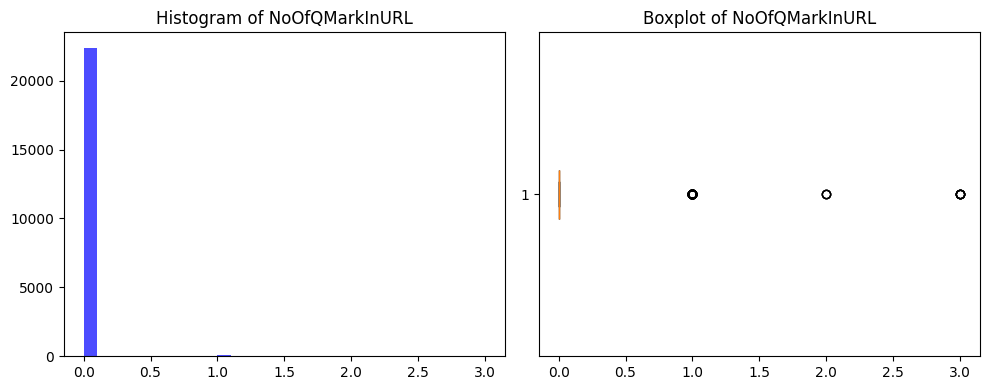

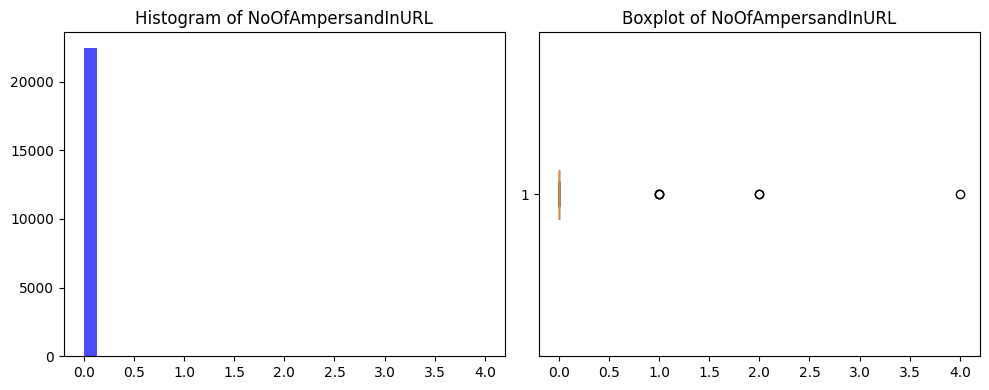

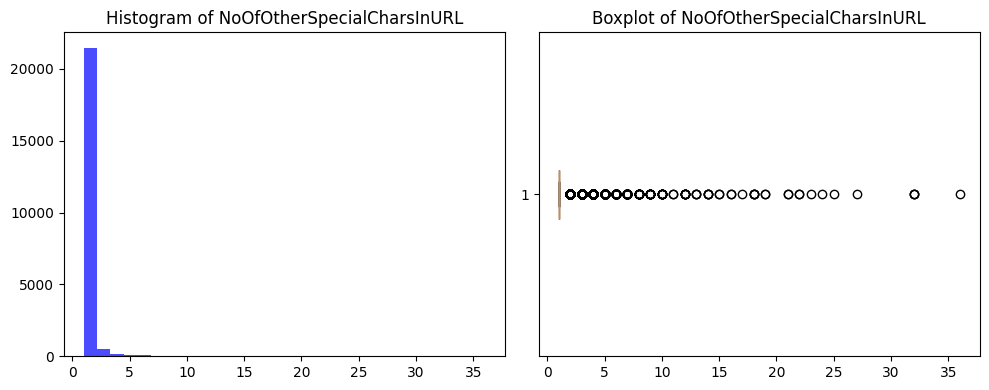

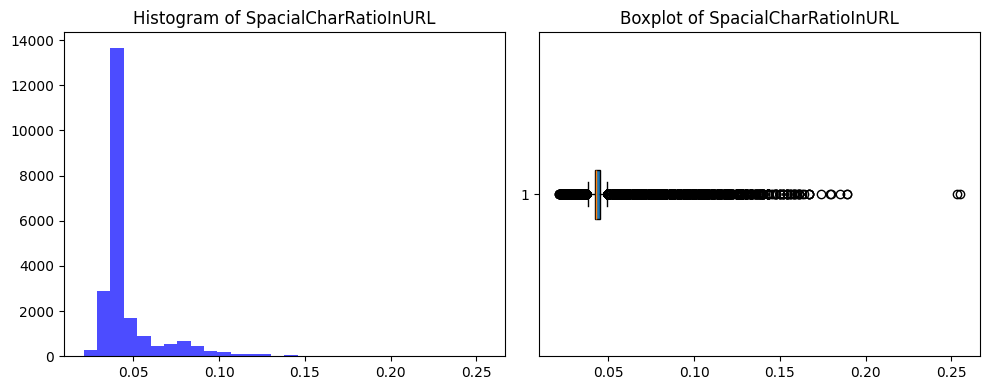

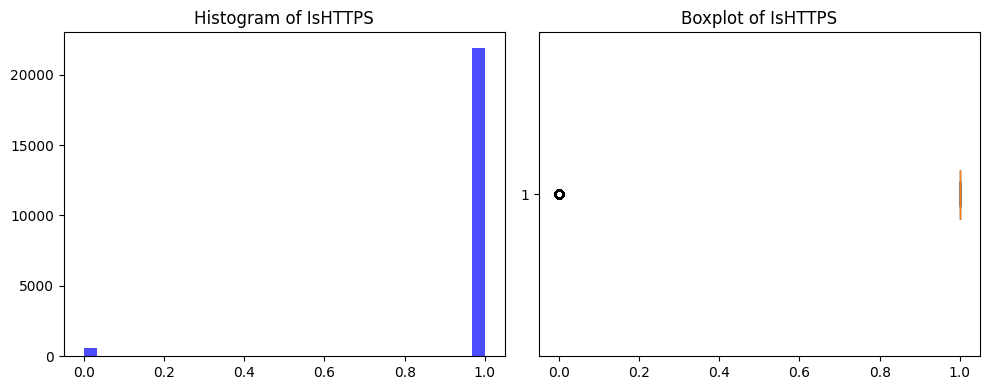

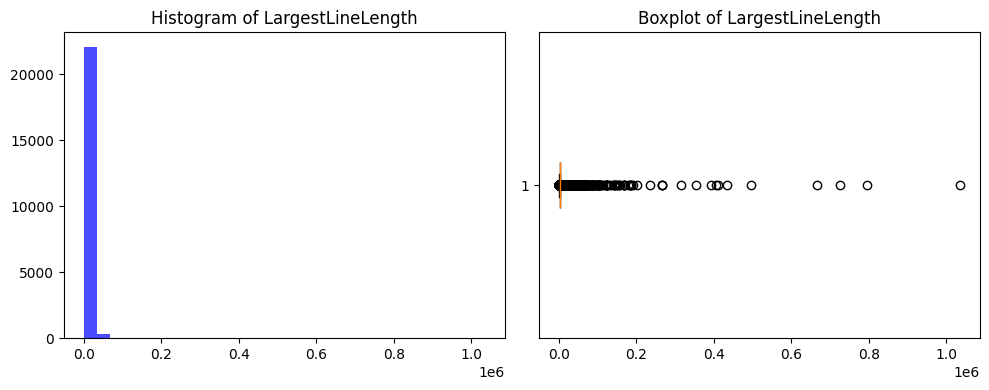

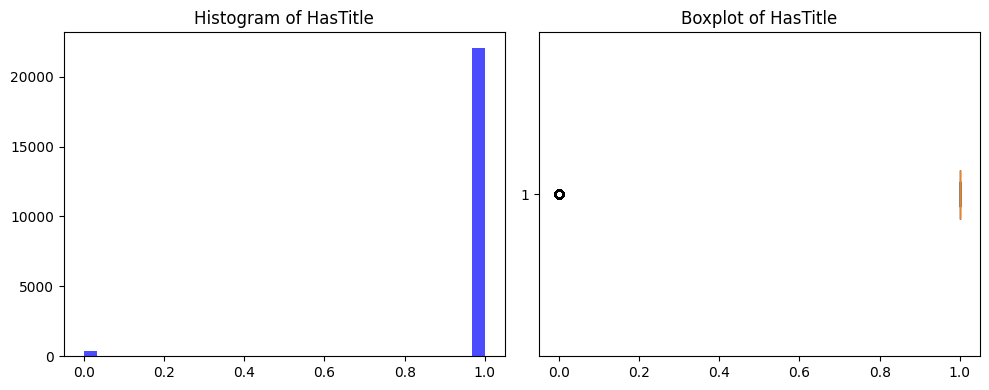

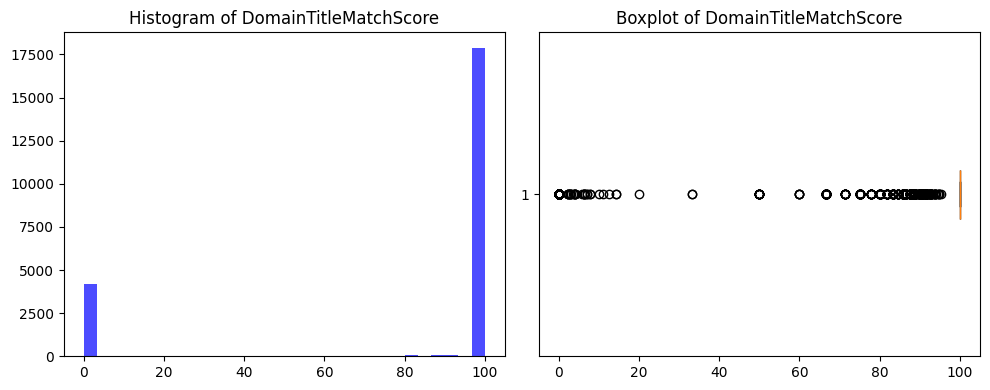

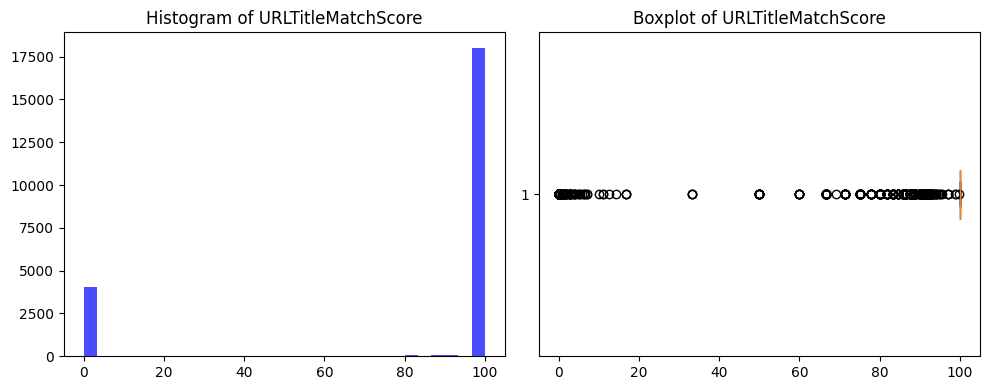

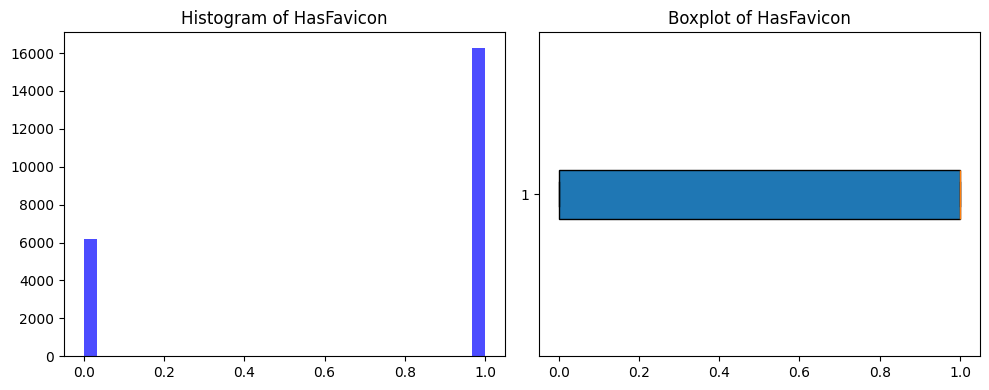

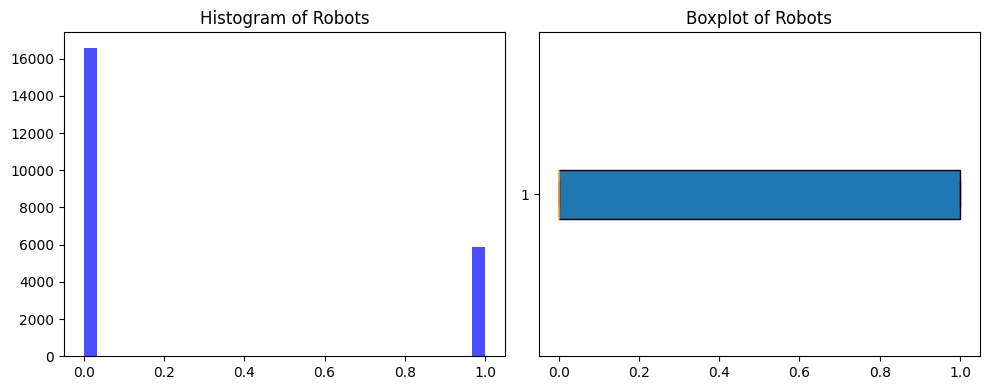

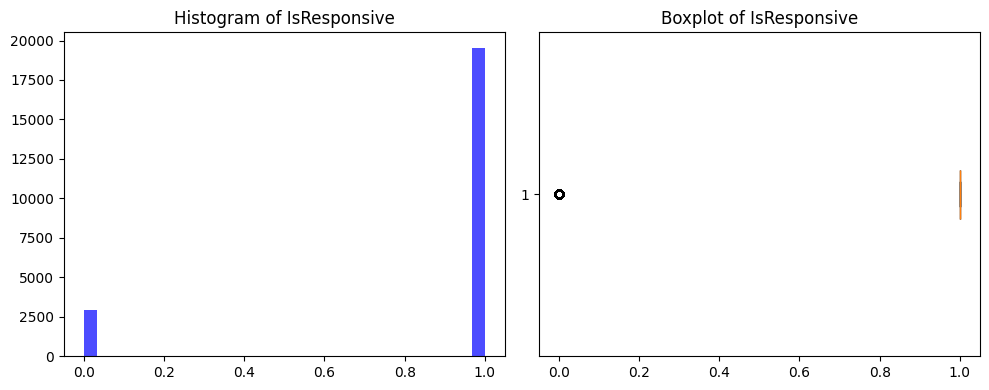

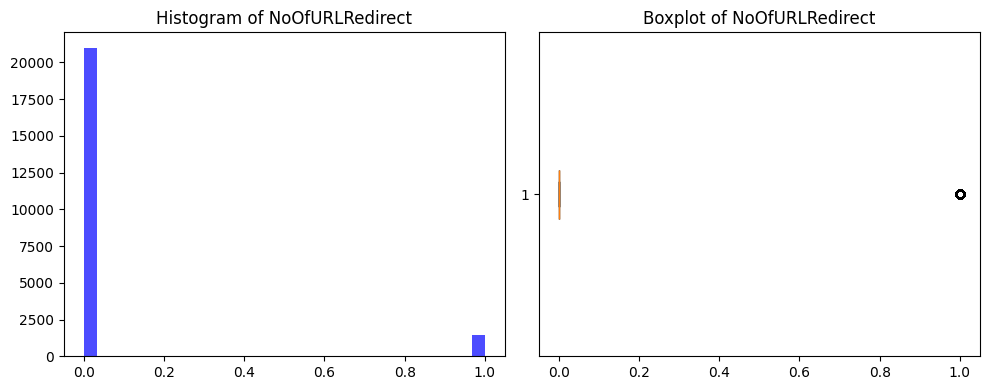

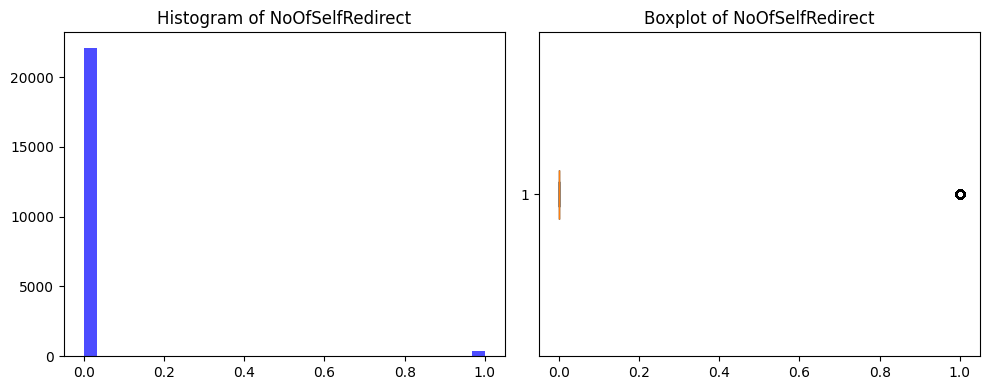

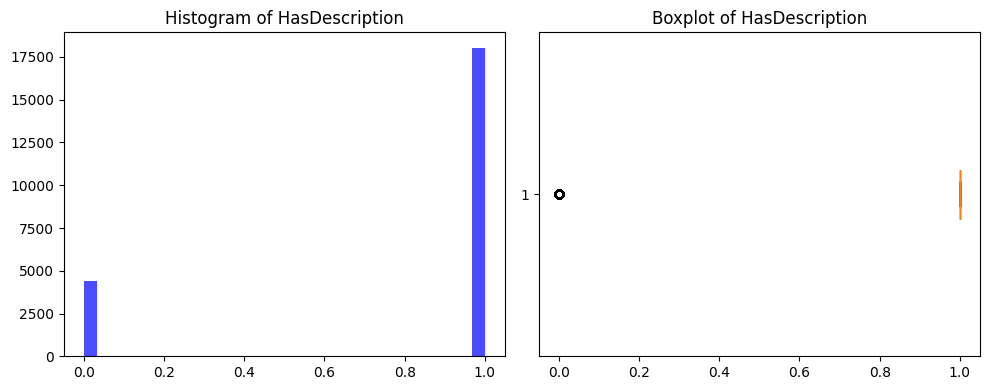

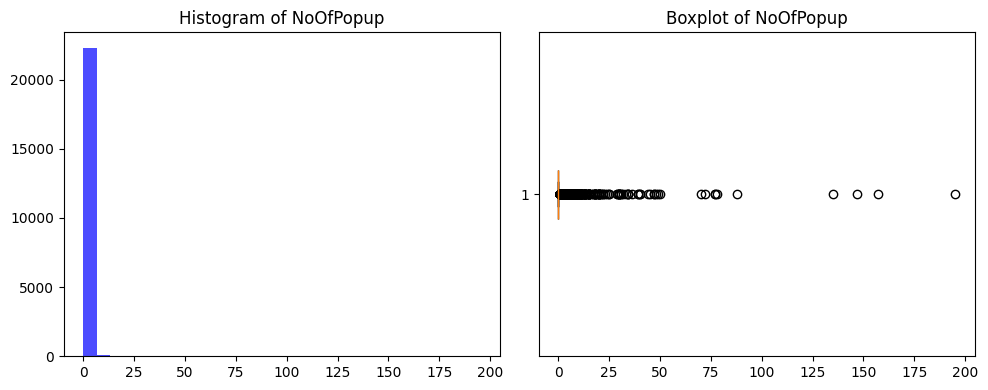

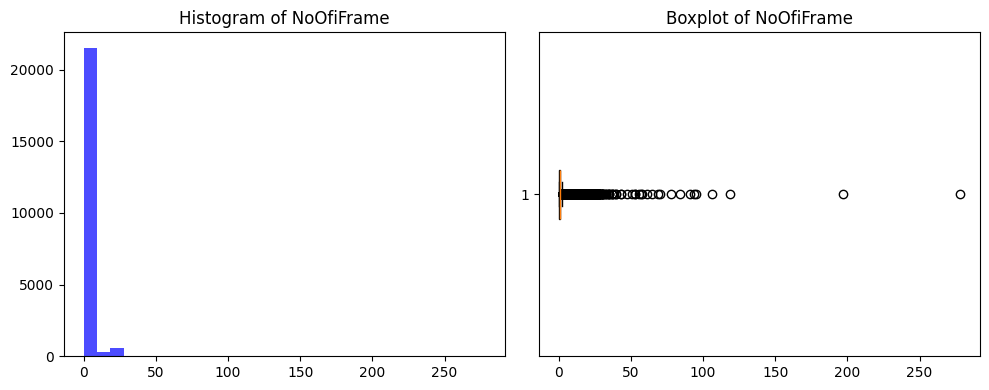

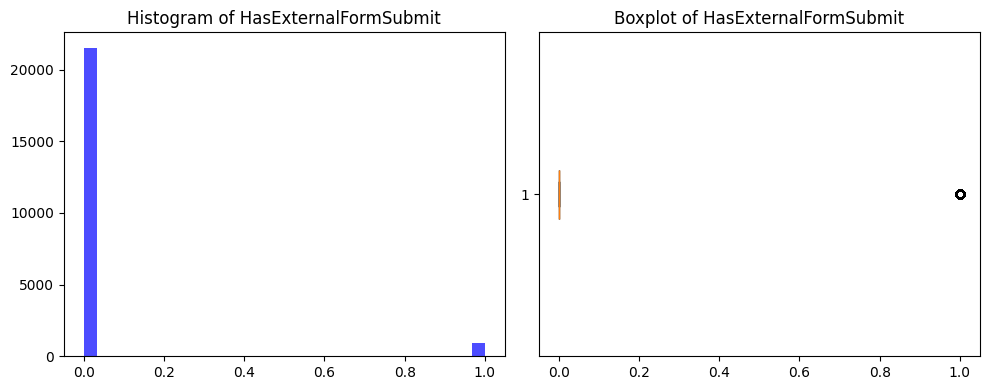

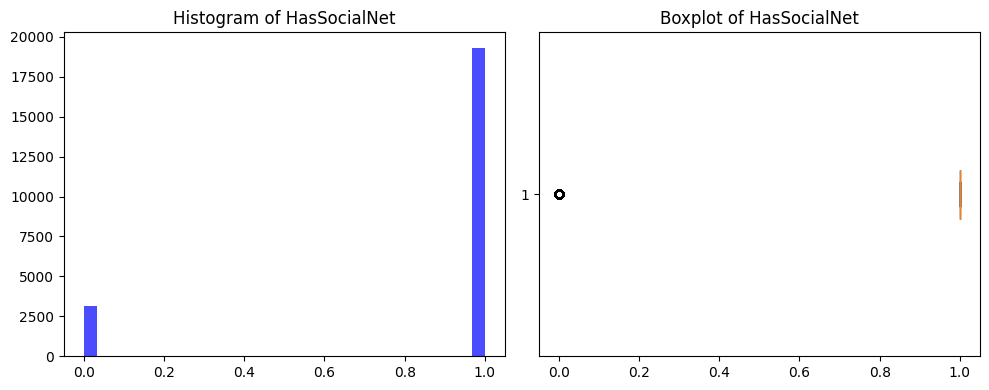

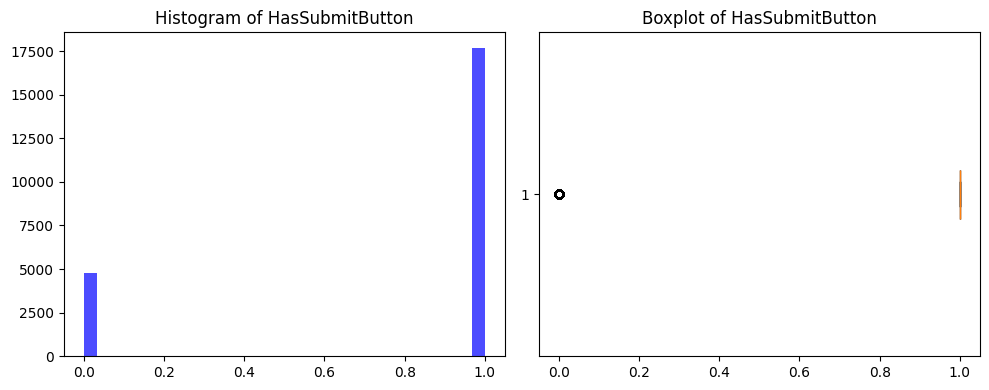

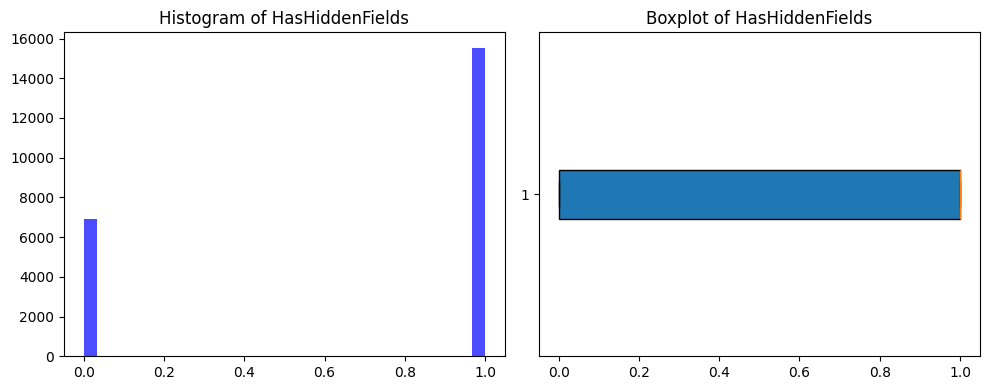

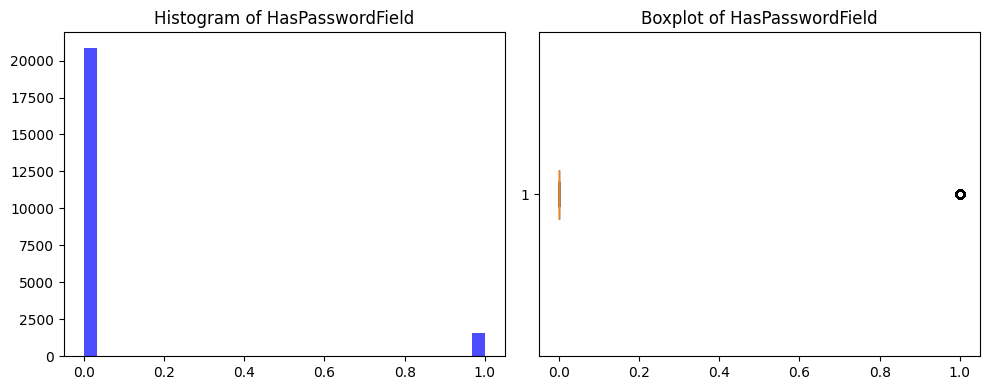

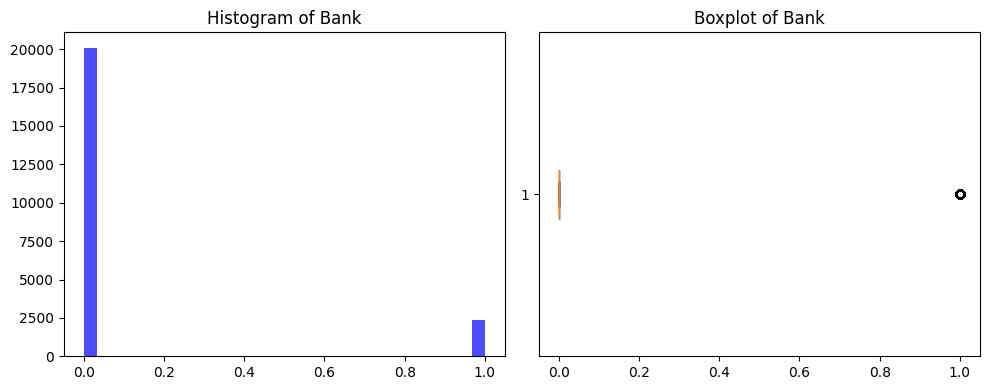

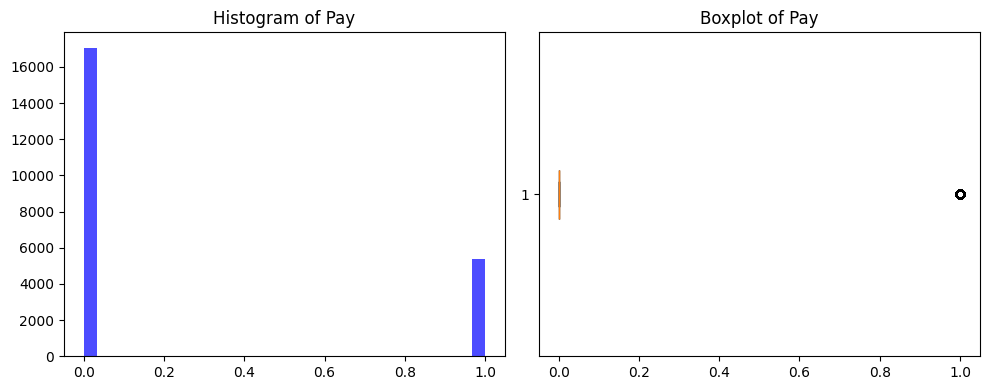

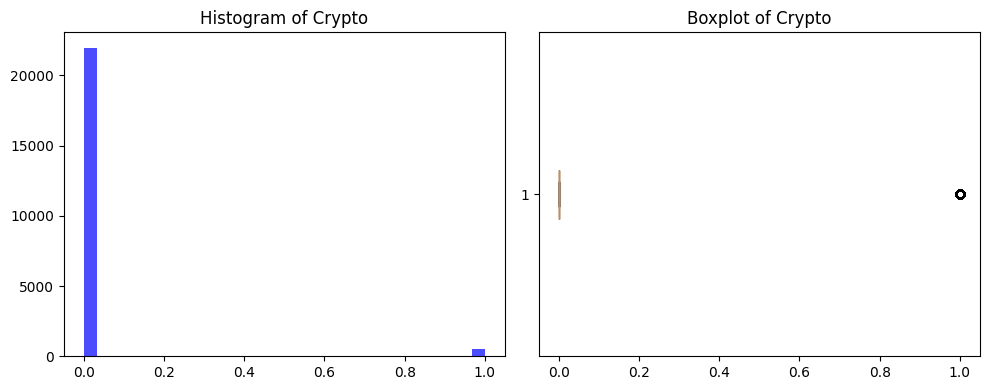

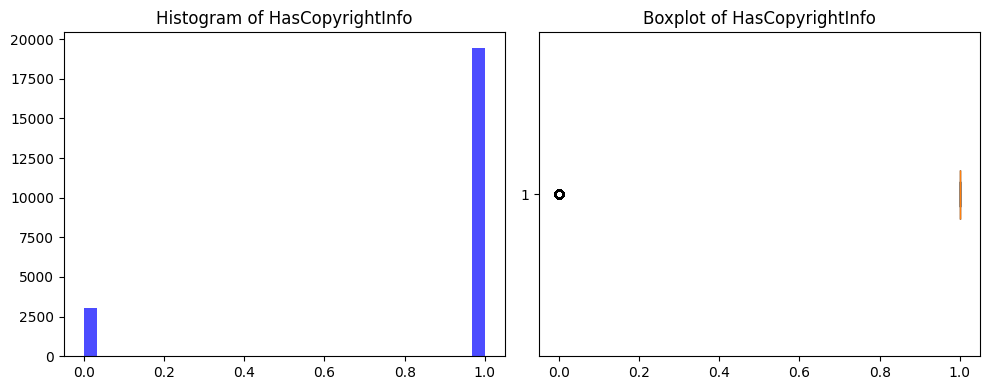

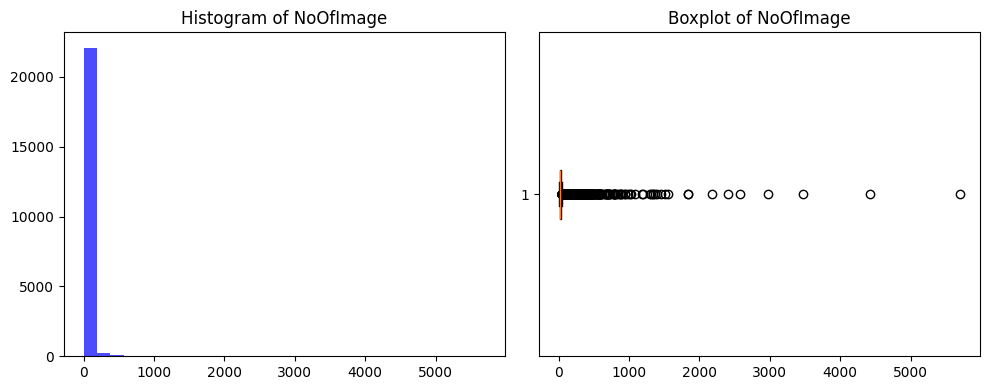

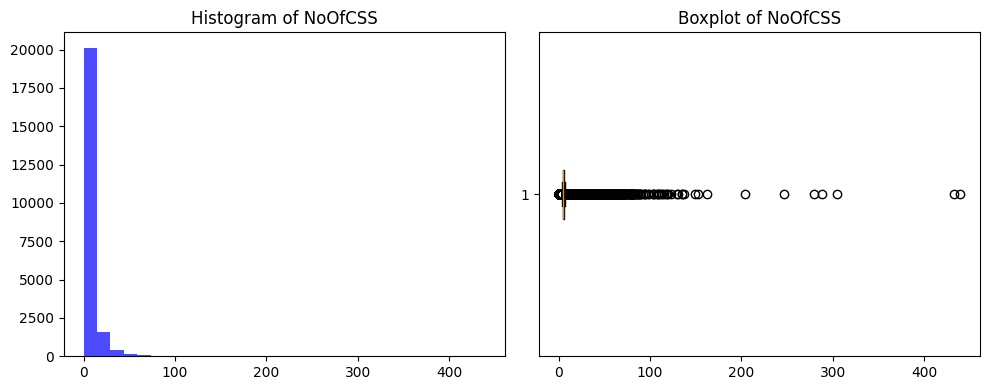

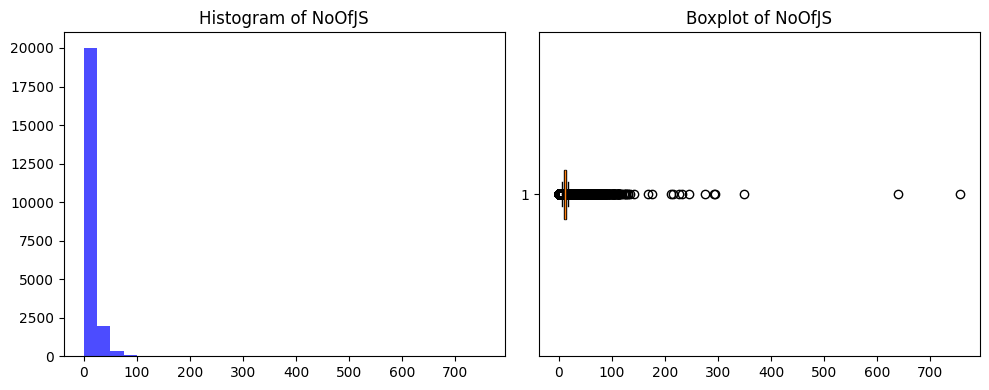

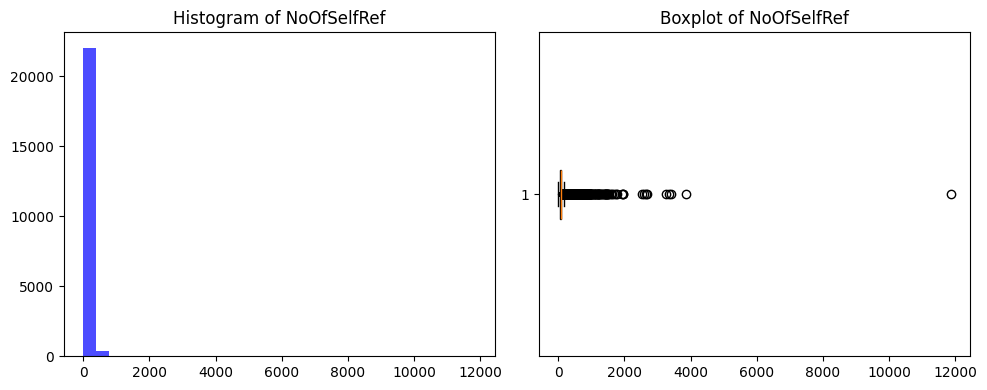

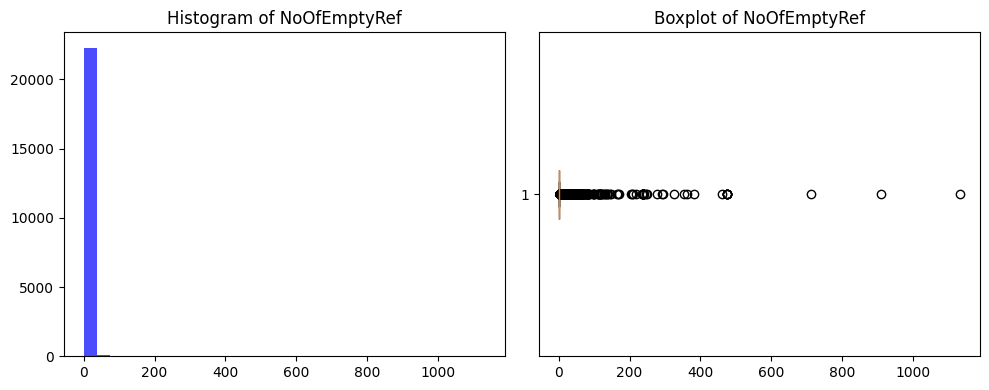

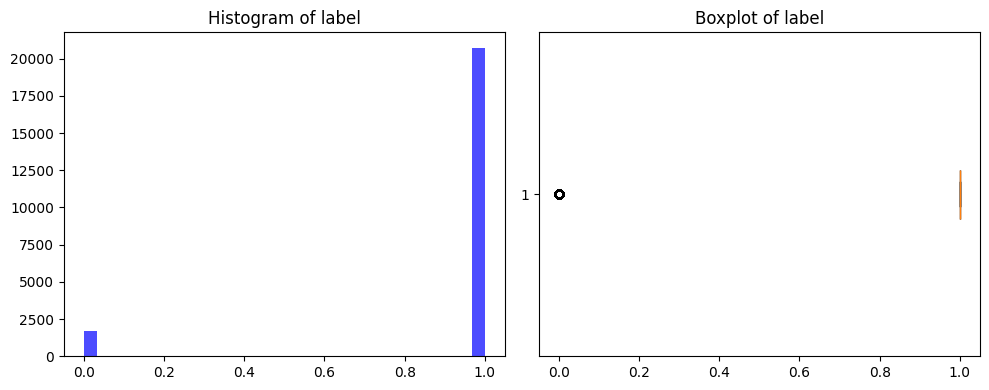

                            IQR Lower Bound  IQR Upper Bound  \
id                           -118858.875000    353732.125000   
URLLength                         22.000000        30.000000   
DomainLength                      11.000000        27.000000   
IsDomainIP                         0.000000         0.000000   
CharContinuationRate               1.000000         1.000000   
TLDLegitimateProb                 -0.584454         1.187324   
URLCharProb                        0.053293         0.066893   
TLDLength                          3.000000         3.000000   
NoOfSubDomain                      1.000000         1.000000   
HasObfuscation                     0.000000         0.000000   
NoOfObfuscatedChar                 0.000000         0.000000   
ObfuscationRatio                   0.000000         0.000000   
NoOfLettersInURL                  10.500000        14.500000   
LetterRatioInURL                   0.450000         0.530000   
NoOfDegitsInURL                    0.000

In [40]:
# Cek dulu kondisi outlier masing2 kolom
numerical_columns = train_set.select_dtypes(include=['float64', 'int64']).columns

outlier_analysis = {}

for col in numerical_columns:
    
    Q1 = train_set[col].quantile(0.25)
    Q3 = train_set[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    
    z_scores = zscore(train_set[col].dropna())
    z_outliers = np.abs(z_scores) > 3  
    
    outlier_analysis[col] = {
        "IQR Lower Bound": lower_bound,
        "IQR Upper Bound": upper_bound,
        "Z-Score Outliers Count": z_outliers.sum(),
        "IQR Outliers Count": ((train_set[col] < lower_bound) | (train_set[col] > upper_bound)).sum(),
        "Skewness": train_set[col].skew()
    }

    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(train_set[col].dropna(), bins=30, color='blue', alpha=0.7)
    plt.title(f'Histogram of {col}')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(train_set[col].dropna(), vert=False, patch_artist=True)
    plt.title(f'Boxplot of {col}')
    
    plt.tight_layout()
    plt.show()

outlier_df = pd.DataFrame(outlier_analysis).T
print(outlier_df)

In [41]:
# Imputasi Outliernya
numerical_columns = train_set.select_dtypes(include=['float64', 'int64']).columns

binary_columns = [col for col in numerical_columns if set(train_set[col].dropna().unique()) <= {0, 1}]

parameters = {}

for col in numerical_columns:
    if col in binary_columns:
        continue  
    
    Q1 = train_set[col].quantile(0.25)
    Q3 = train_set[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    parameters[col] = {'lower_bound': lower_bound, 'upper_bound': upper_bound}
    
    train_set[col] = train_set[col].clip(lower=lower_bound, upper=upper_bound)

for col in numerical_columns:
    if col in binary_columns:
        continue  

    lower_bound = parameters[col]['lower_bound']
    upper_bound = parameters[col]['upper_bound']

    
    val_set[col] = val_set[col].clip(lower=lower_bound, upper=upper_bound)


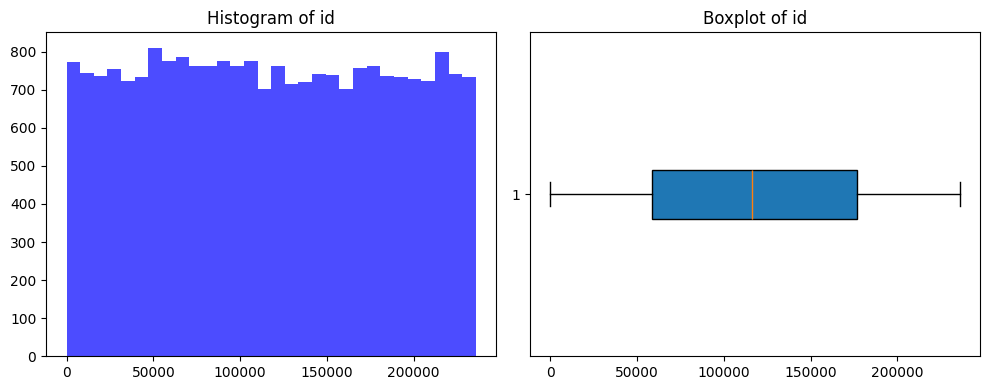

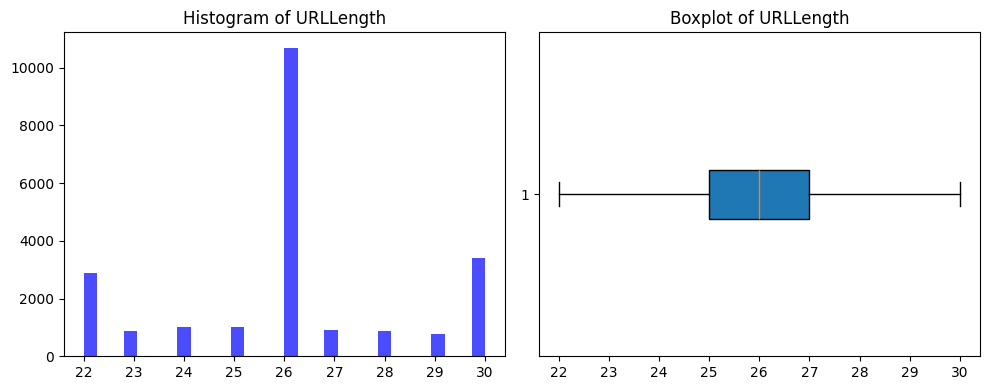

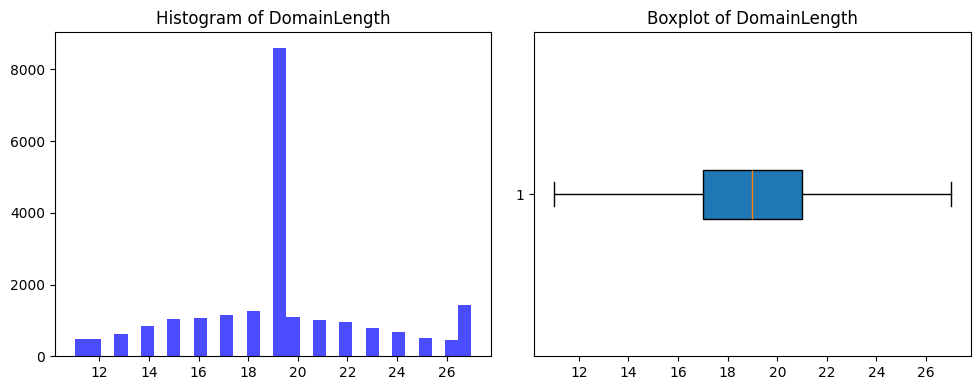

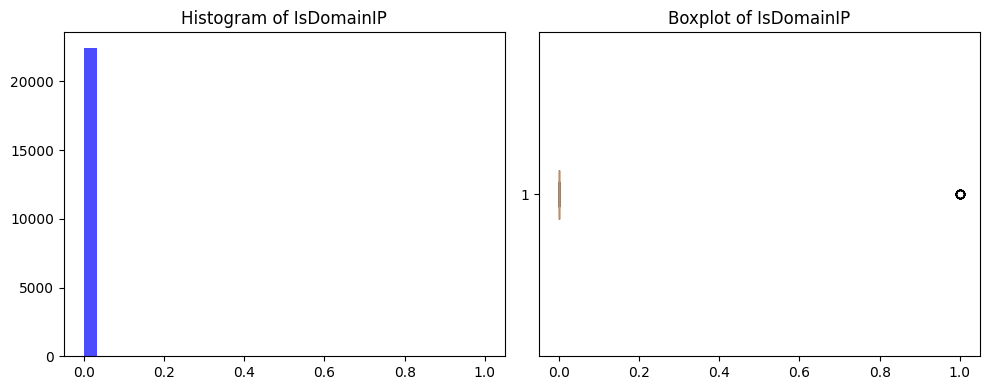

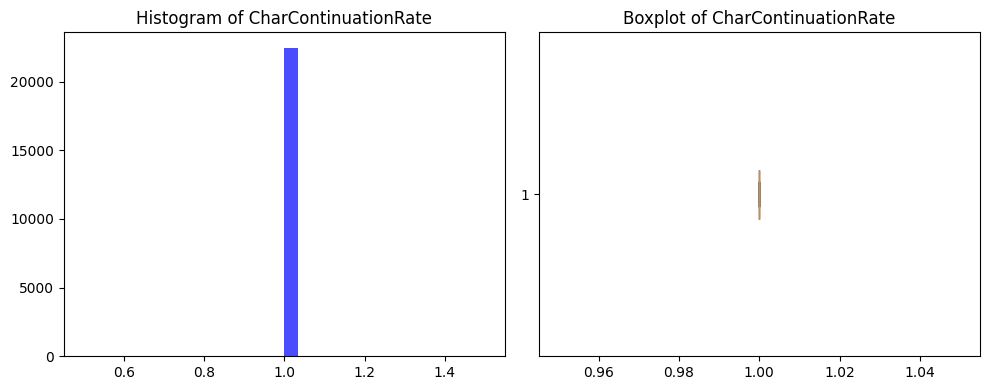

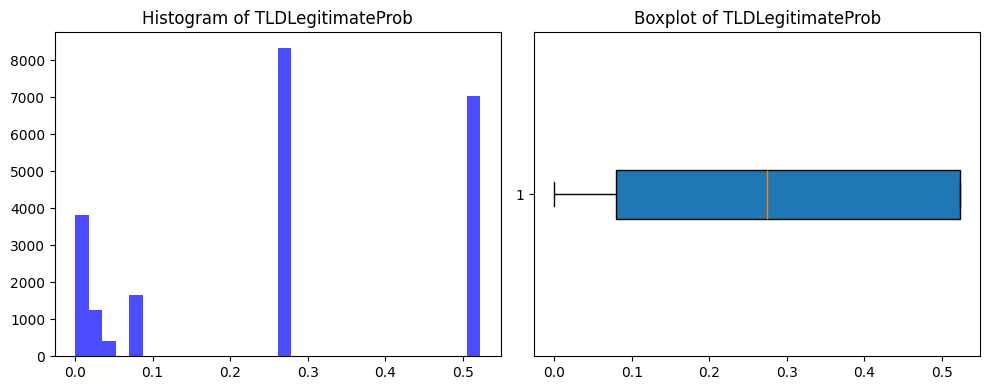

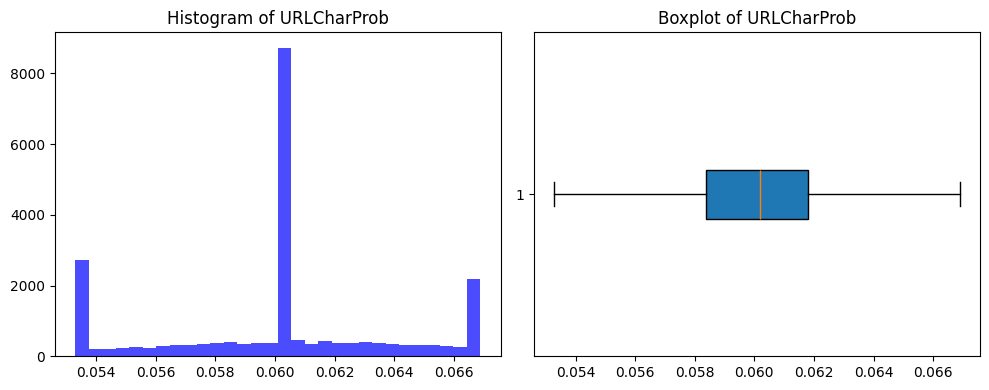

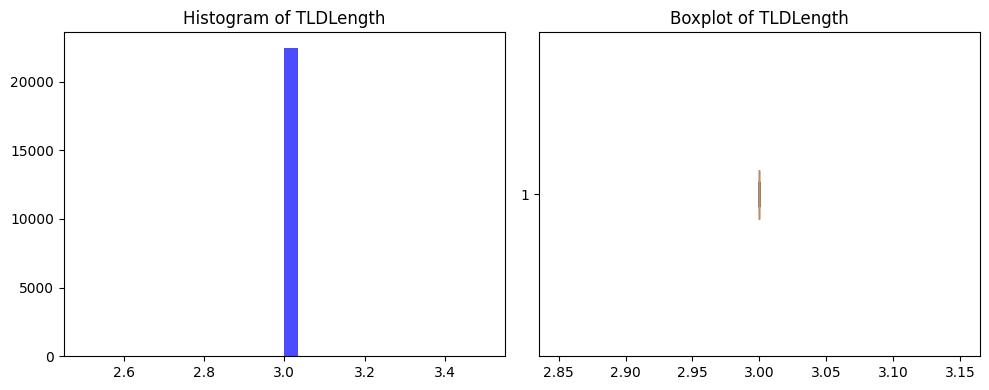

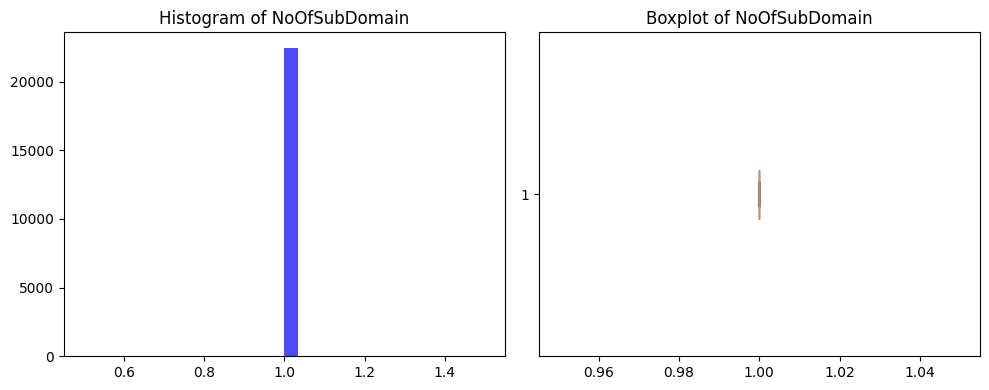

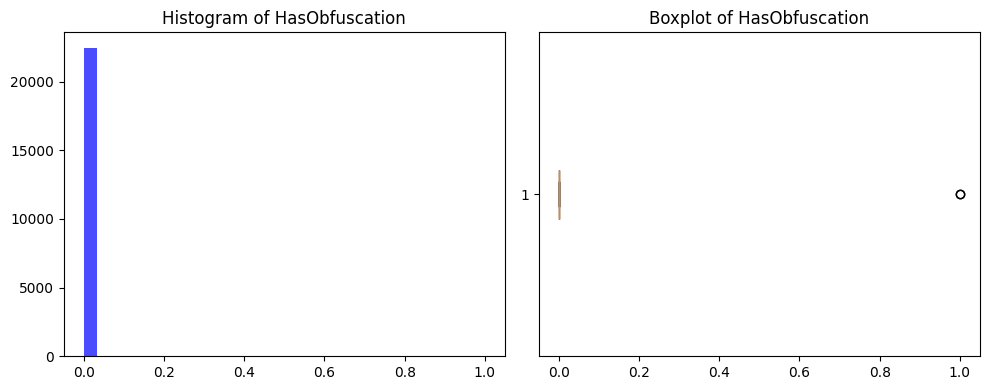

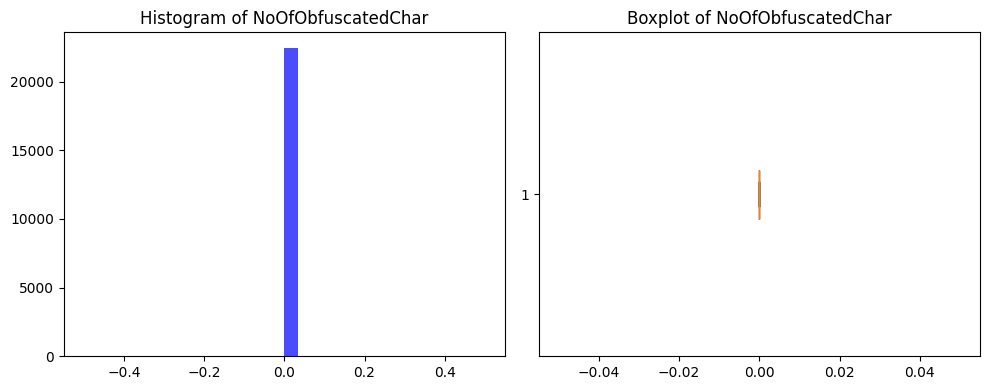

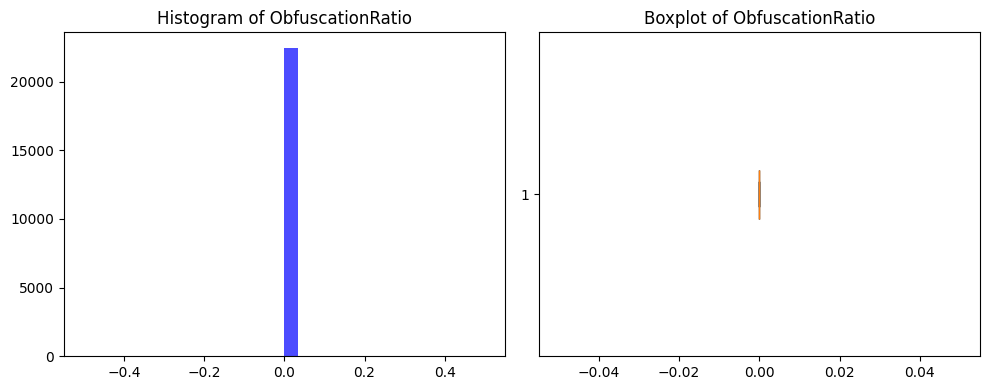

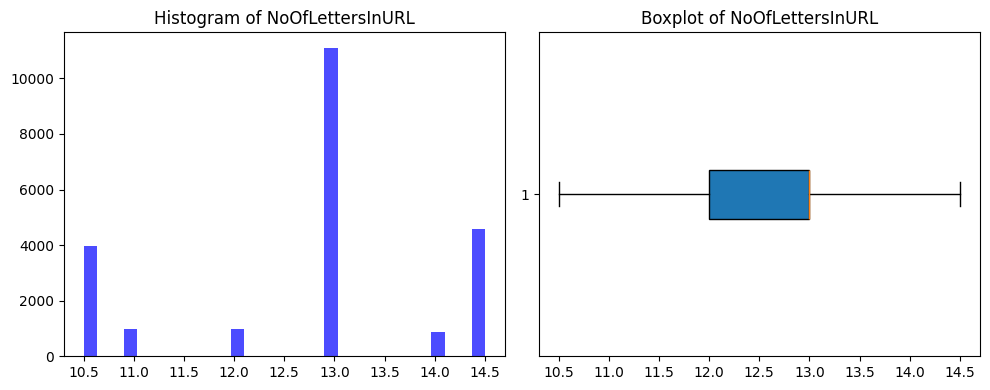

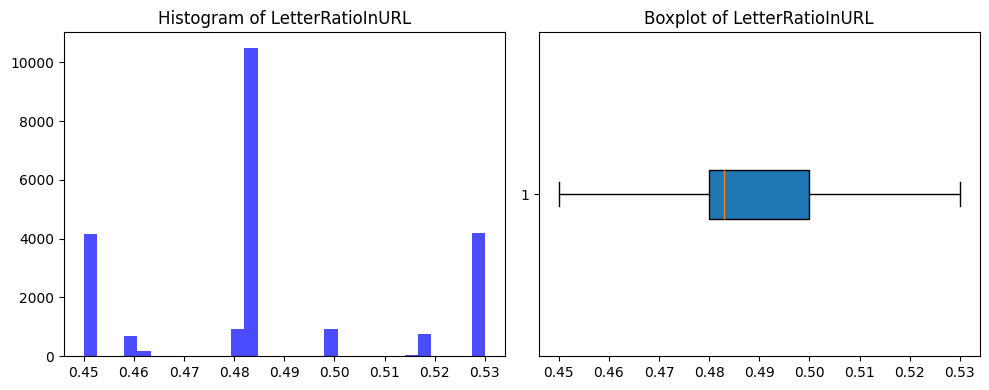

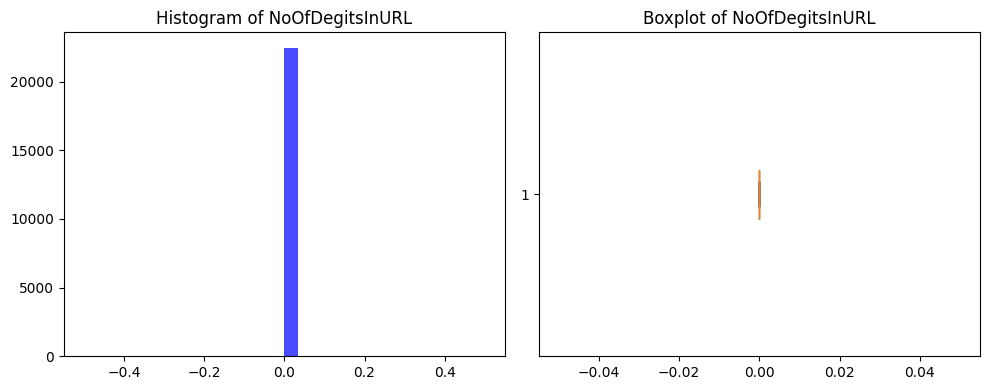

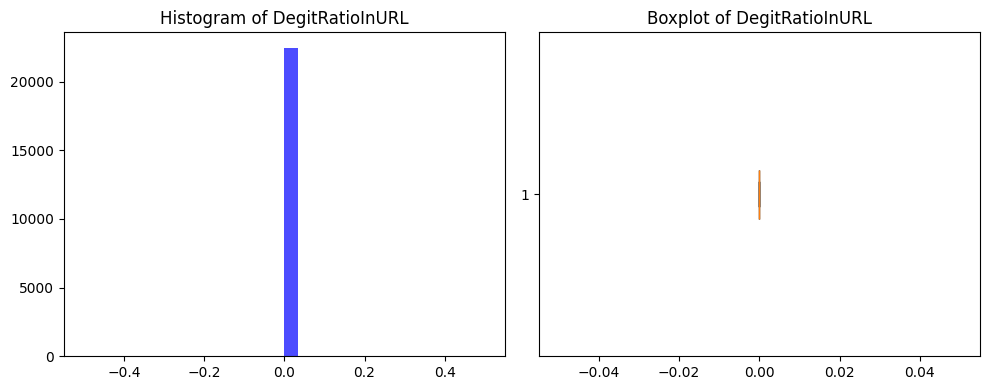

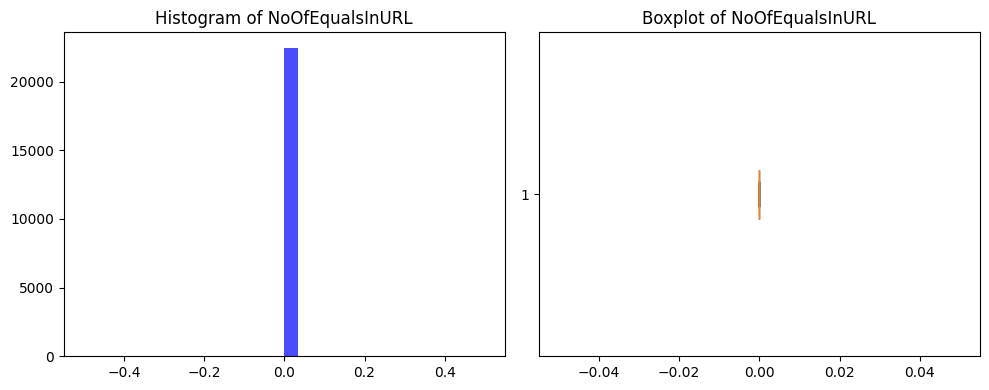

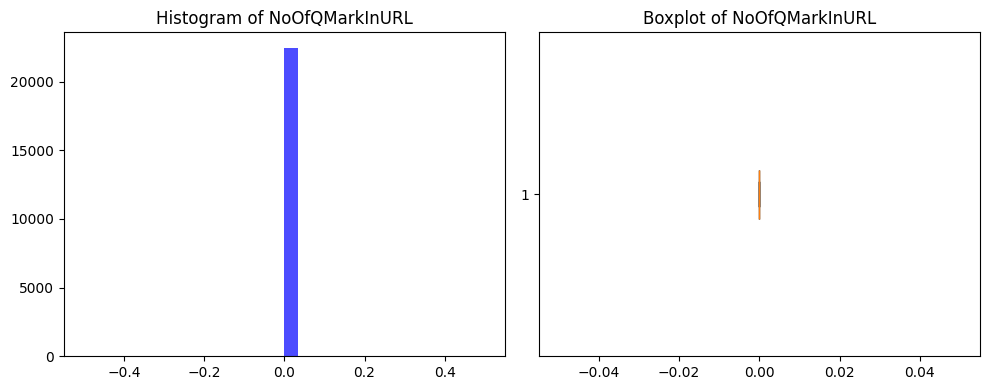

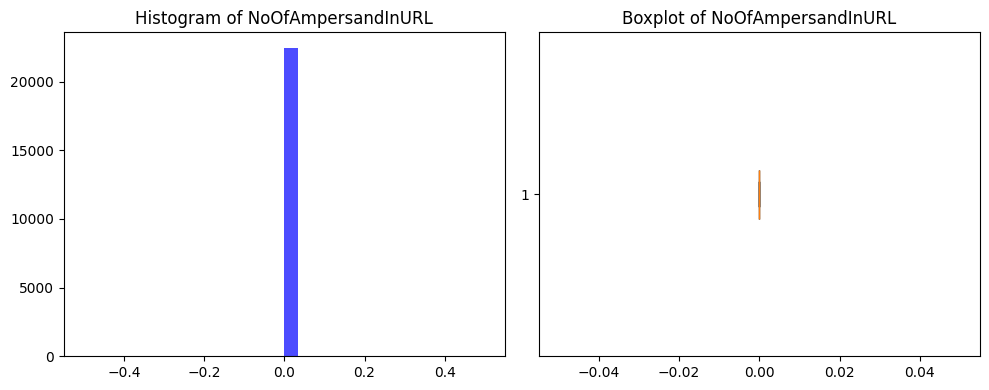

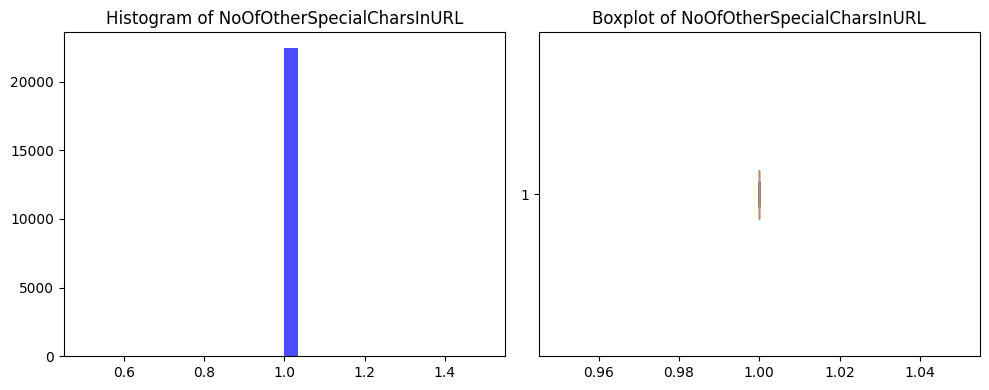

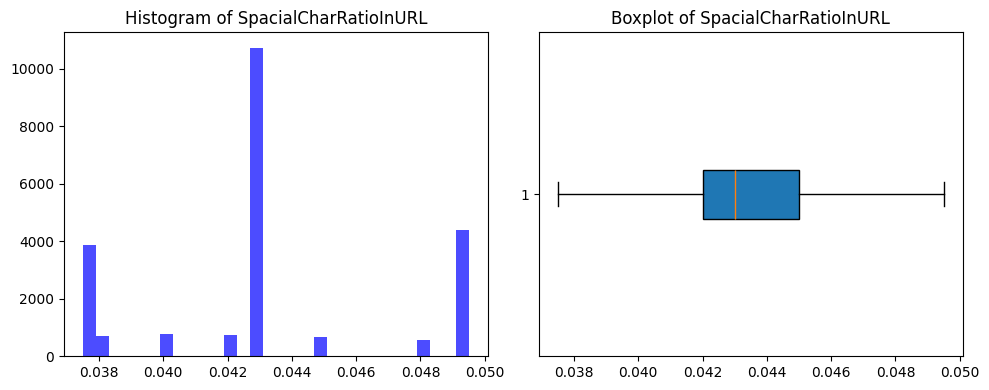

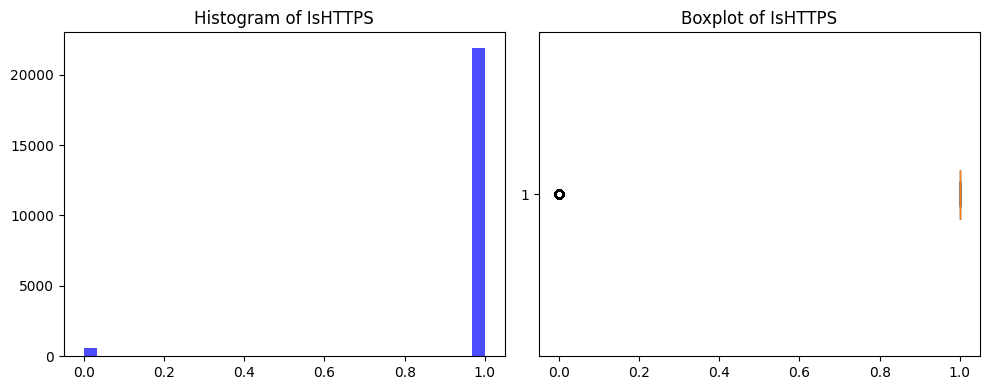

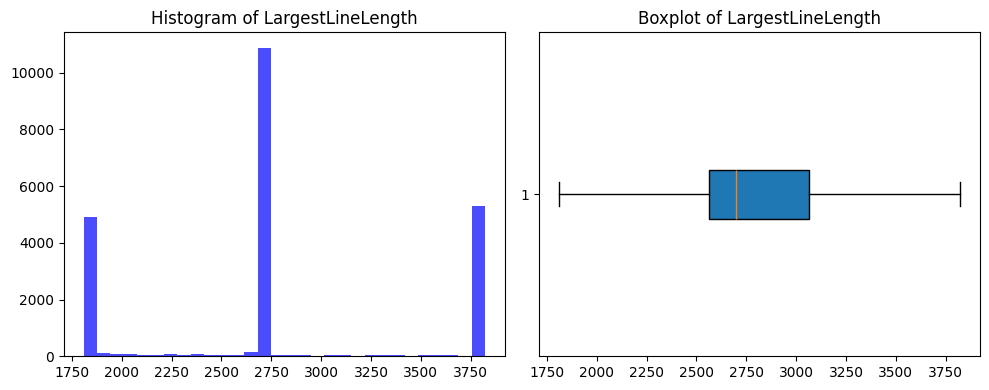

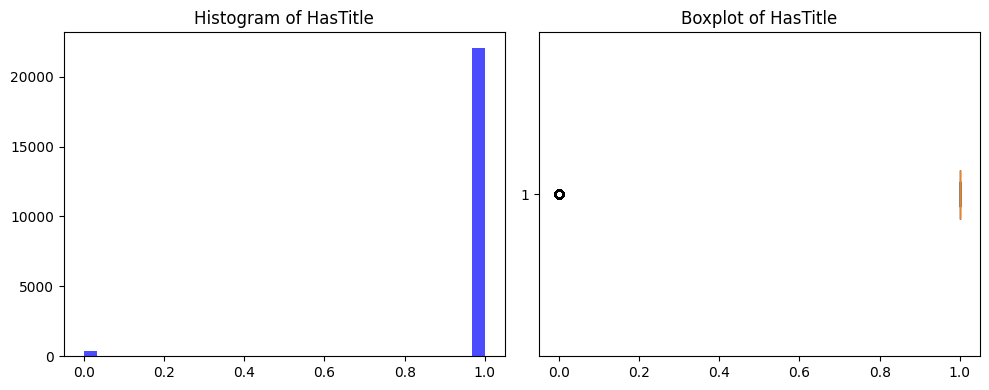

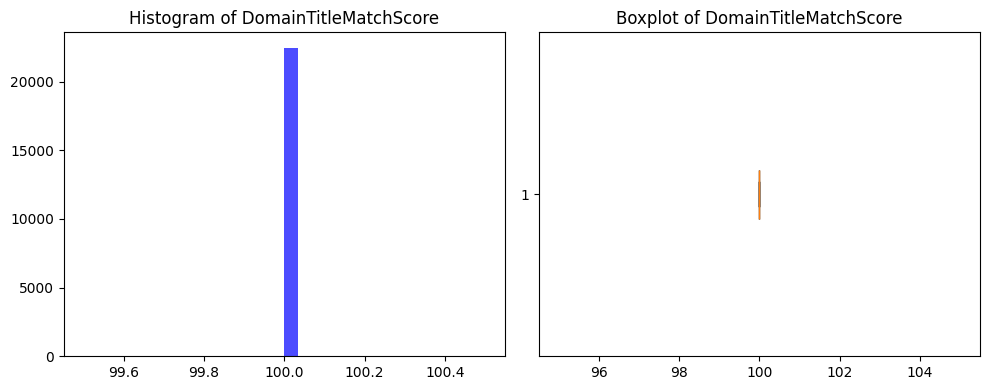

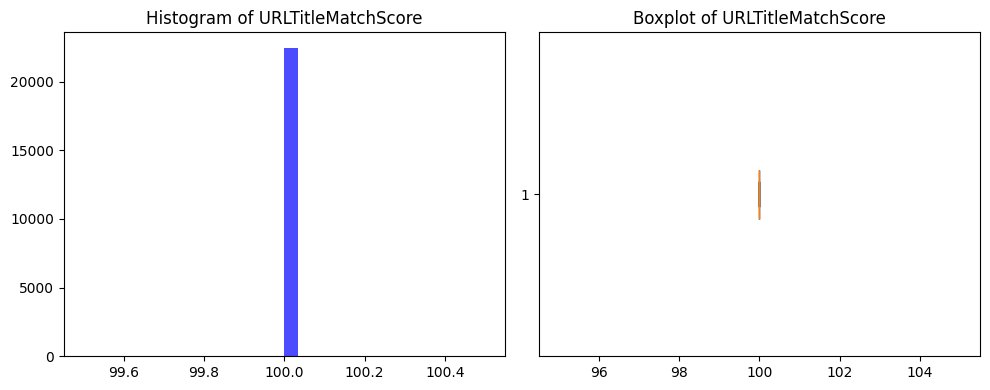

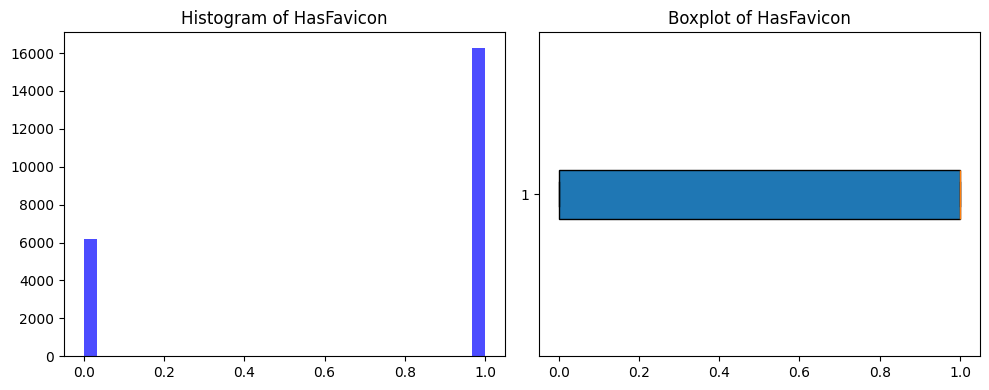

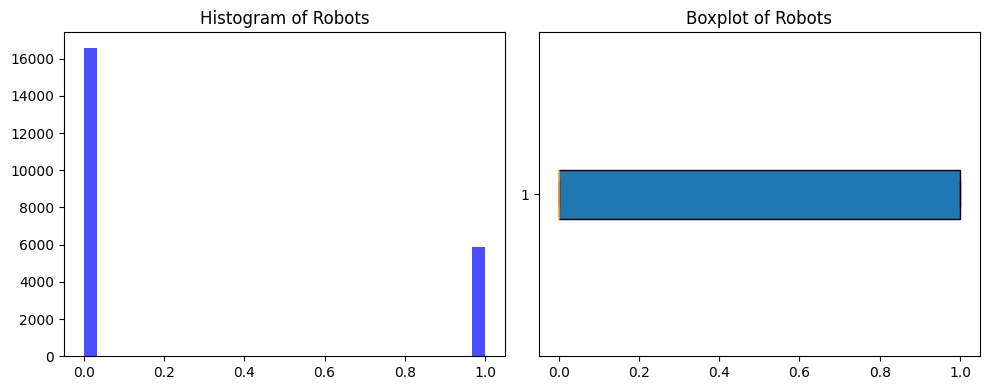

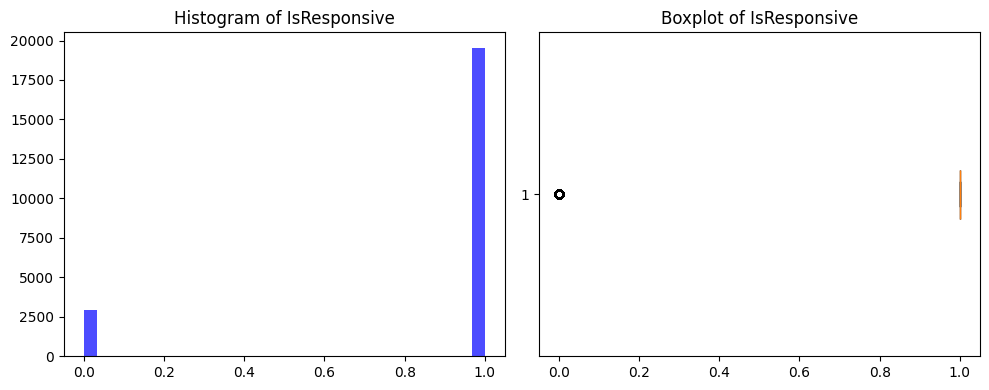

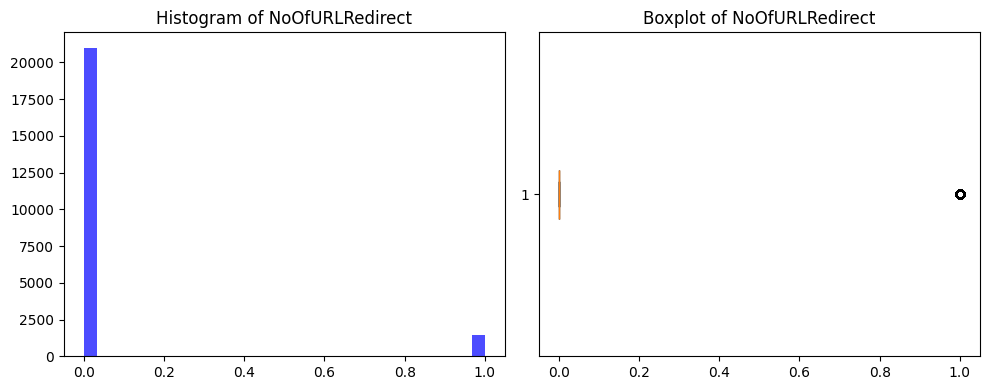

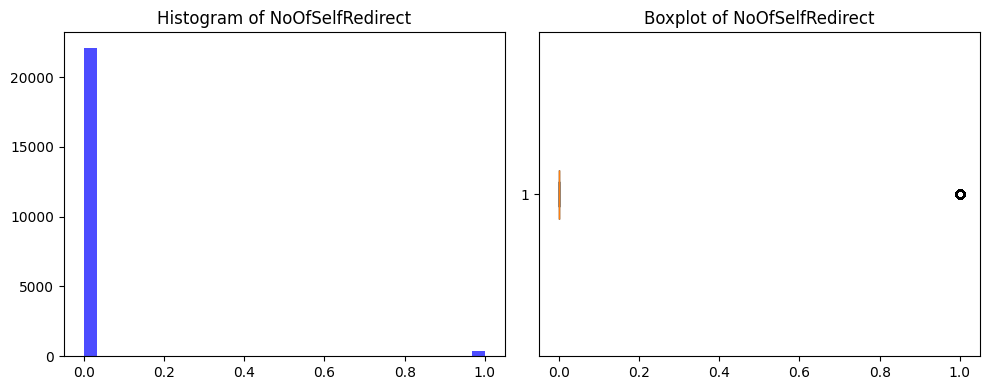

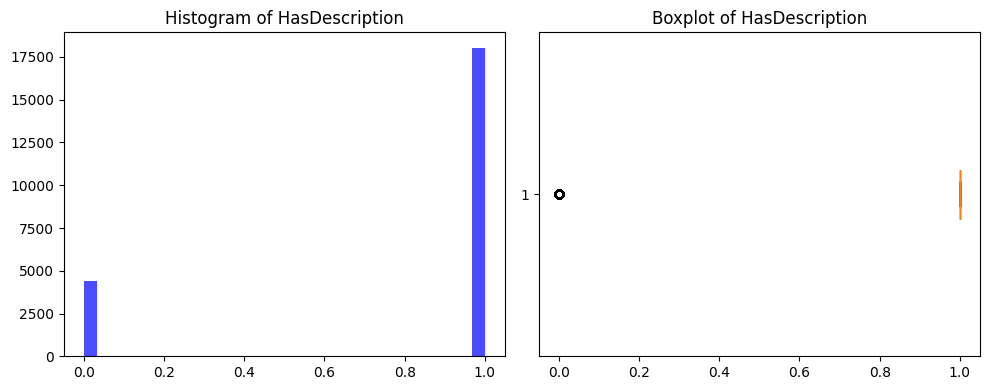

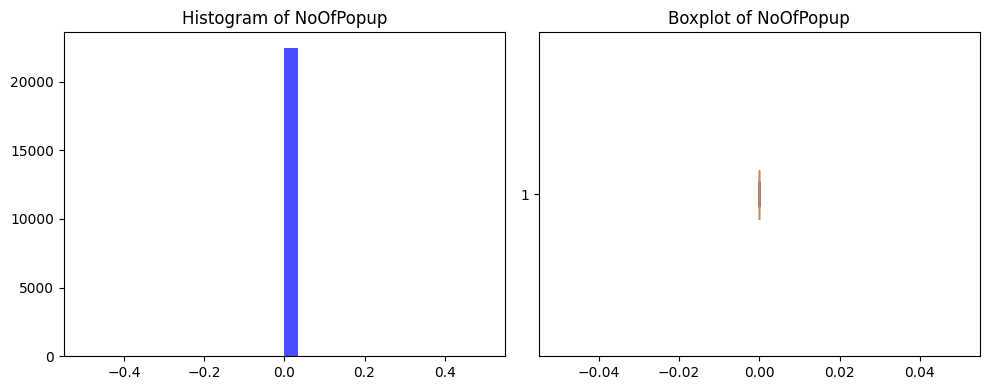

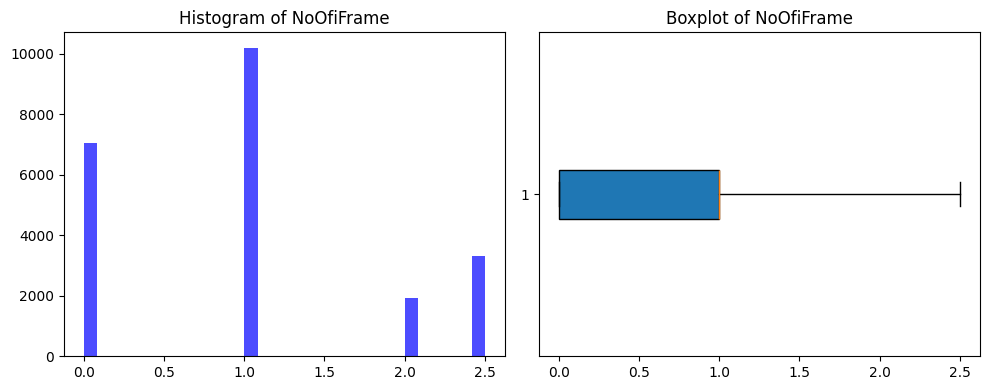

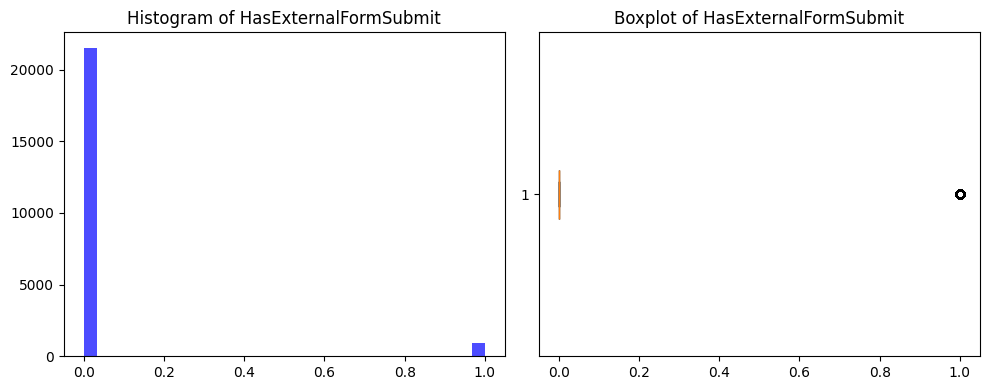

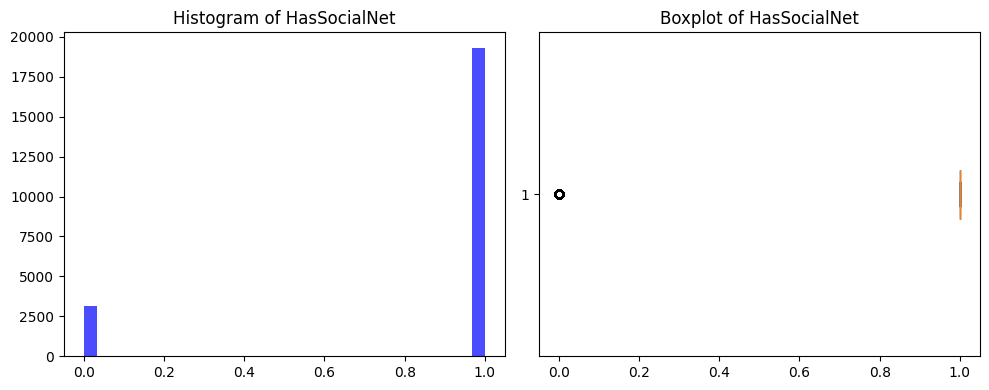

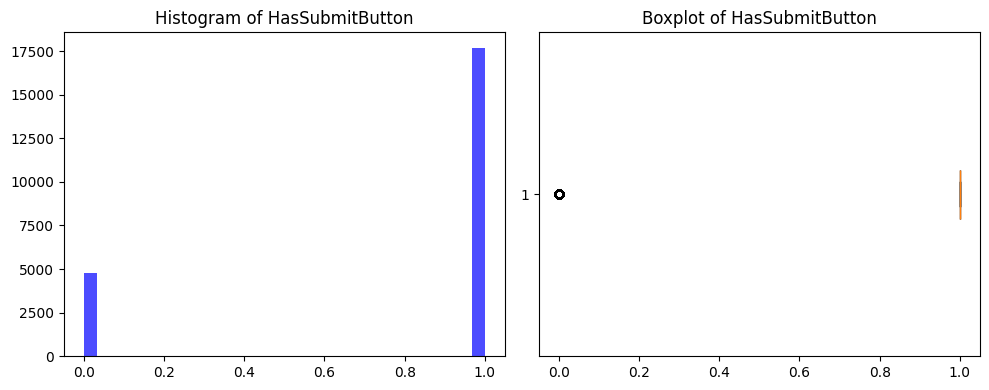

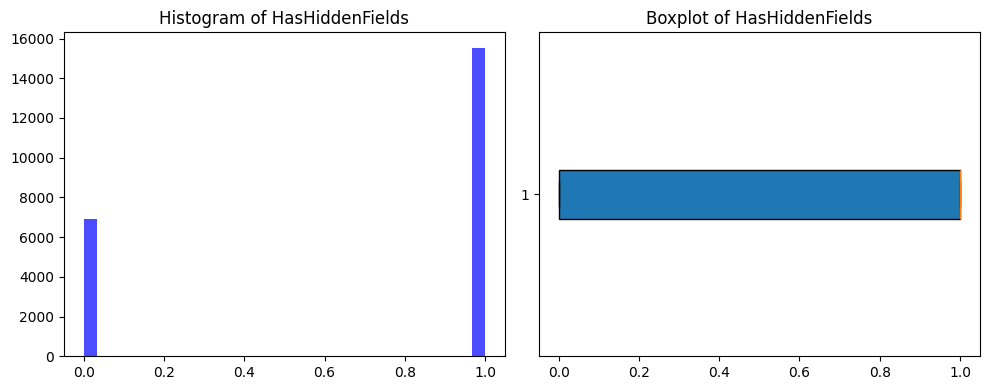

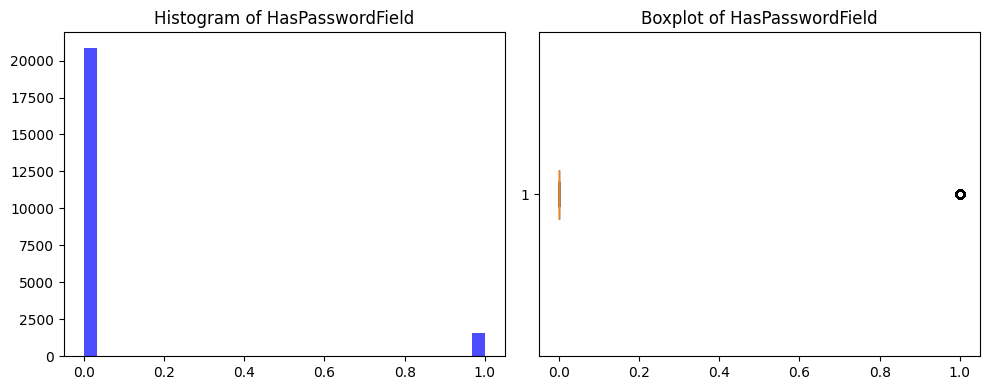

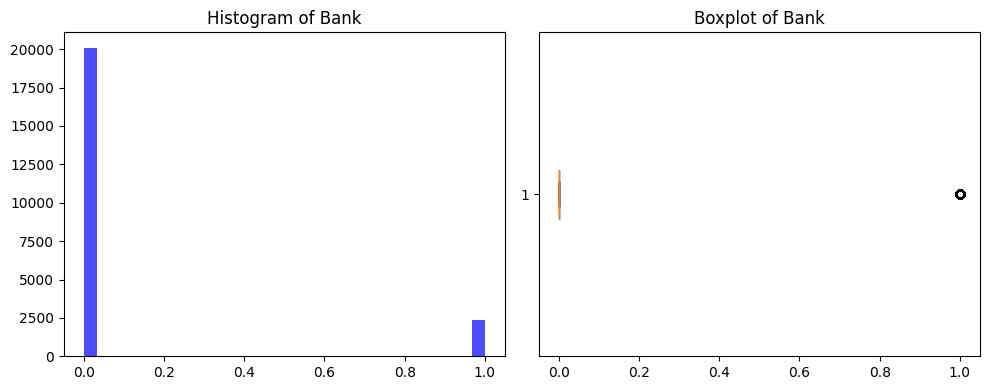

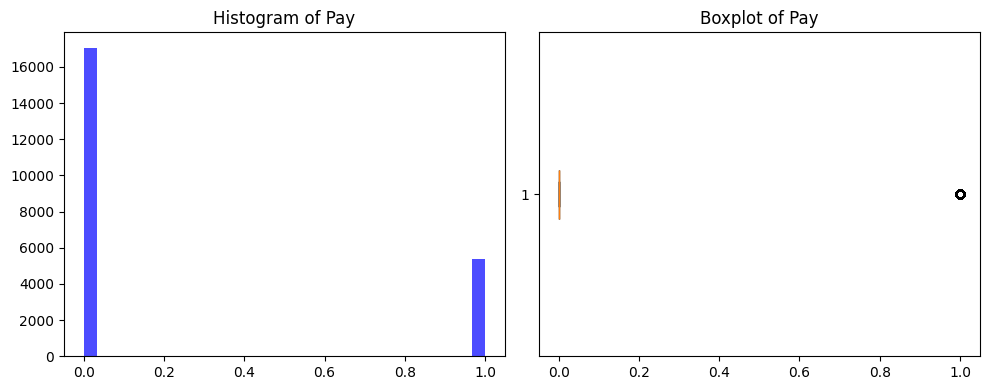

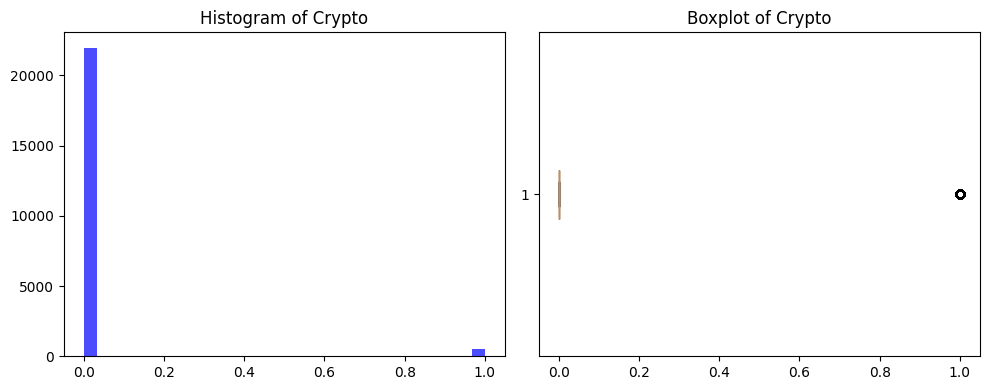

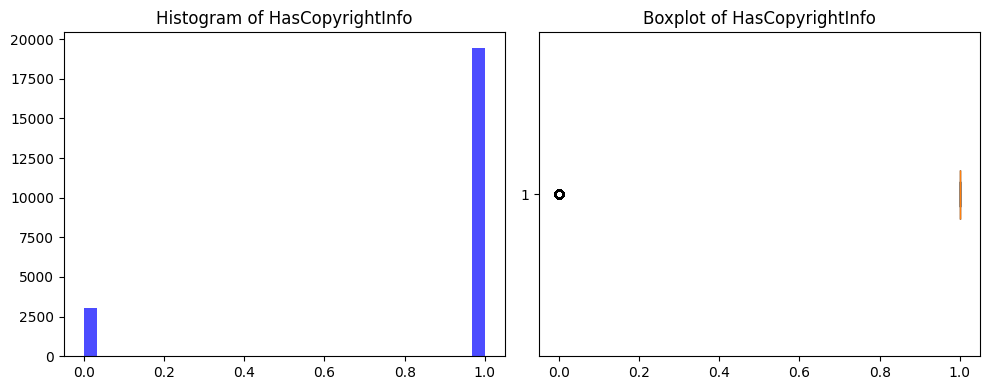

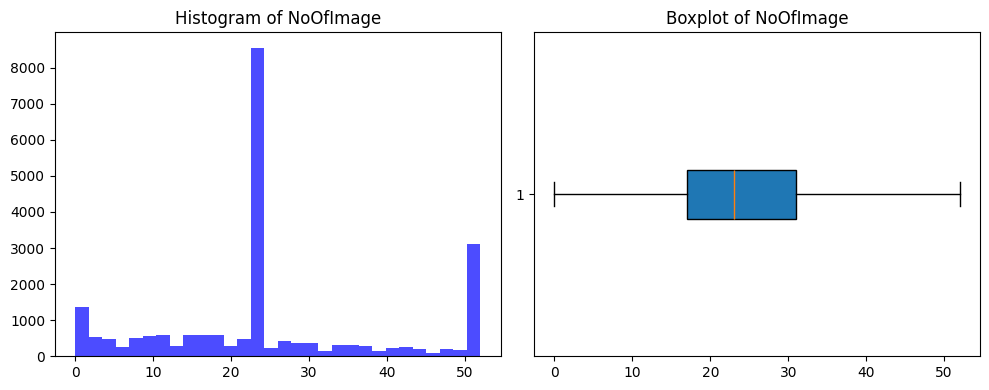

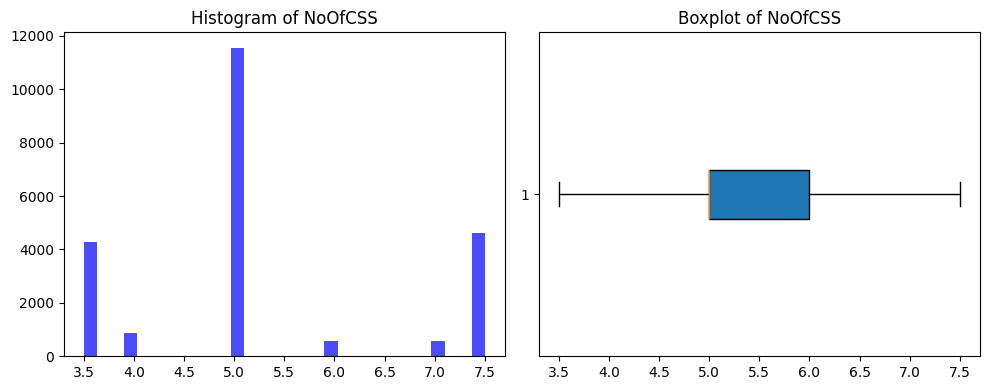

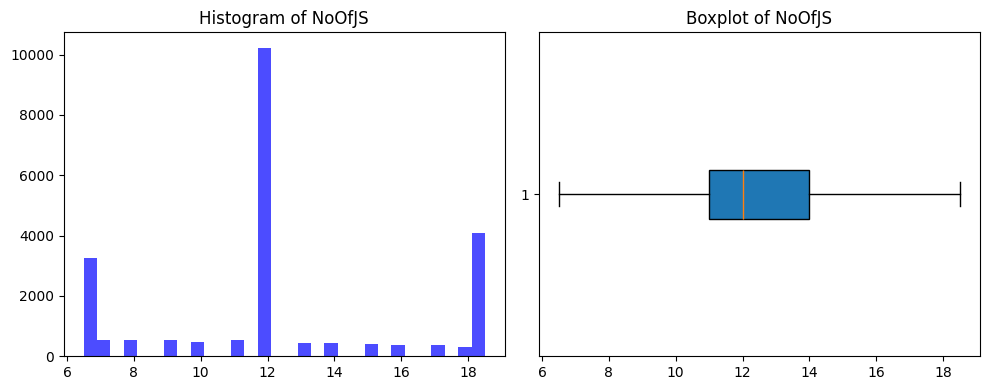

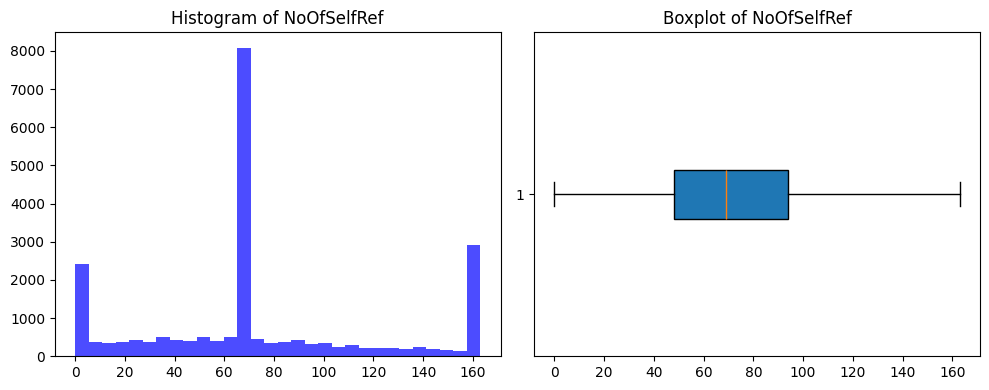

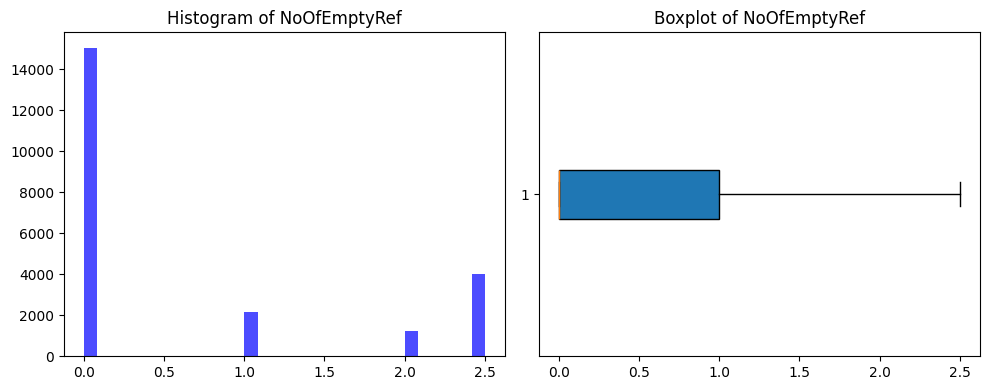

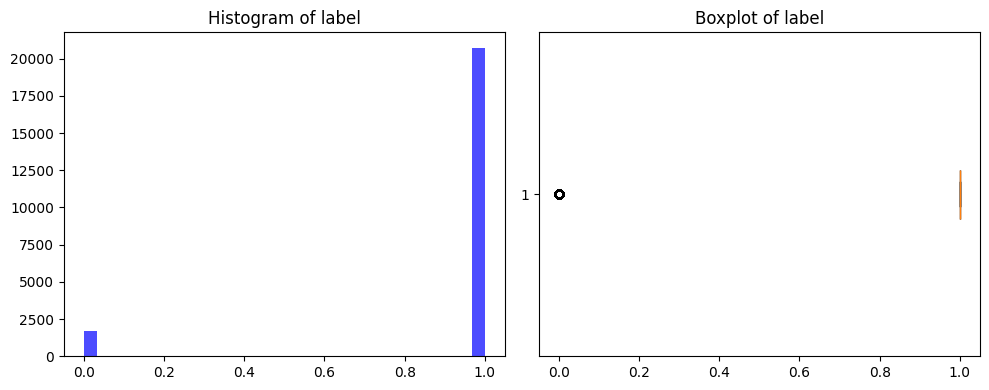

                            IQR Lower Bound  IQR Upper Bound  \
id                           -118858.875000    353732.125000   
URLLength                         22.000000        30.000000   
DomainLength                      11.000000        27.000000   
IsDomainIP                         0.000000         0.000000   
CharContinuationRate               1.000000         1.000000   
TLDLegitimateProb                 -0.584454         1.187324   
URLCharProb                        0.053293         0.066893   
TLDLength                          3.000000         3.000000   
NoOfSubDomain                      1.000000         1.000000   
HasObfuscation                     0.000000         0.000000   
NoOfObfuscatedChar                 0.000000         0.000000   
ObfuscationRatio                   0.000000         0.000000   
NoOfLettersInURL                  10.500000        14.500000   
LetterRatioInURL                   0.450000         0.530000   
NoOfDegitsInURL                    0.000

In [42]:
# Cek lagi kondisi outlier masing2 kolom
numerical_columns = train_set.select_dtypes(include=['float64', 'int64']).columns


outlier_analysis = {}

for col in numerical_columns:
    
    Q1 = train_set[col].quantile(0.25)
    Q3 = train_set[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    
    z_scores = zscore(train_set[col].dropna())
    z_outliers = np.abs(z_scores) > 3  

    
    outlier_analysis[col] = {
        "IQR Lower Bound": lower_bound,
        "IQR Upper Bound": upper_bound,
        "Z-Score Outliers Count": z_outliers.sum(),
        "IQR Outliers Count": ((train_set[col] < lower_bound) | (train_set[col] > upper_bound)).sum(),
        "Skewness": train_set[col].skew()
    }
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(train_set[col].dropna(), bins=30, color='blue', alpha=0.7)
    plt.title(f'Histogram of {col}')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(train_set[col].dropna(), vert=False, patch_artist=True)
    plt.title(f'Boxplot of {col}')
    
    plt.tight_layout()
    plt.show()

outlier_df = pd.DataFrame(outlier_analysis).T
print(outlier_df)


Sudah lebih baik untuk persebaran dan nilai-nilai ouliernya, meskipun metode clipping membuat penumpukan data di nilai min dan max

### IV. Feature Engineering

**Feature engineering** involves creating new features (input variables) or transforming existing ones to improve the performance of machine learning models. Feature engineering aims to enhance the model's ability to learn patterns and make accurate predictions from the data. It's often said that "good features make good models."

1. **Feature Selection:** Feature engineering can involve selecting the most relevant and informative features from the dataset. Removing irrelevant or redundant features not only simplifies the model but also reduces the risk of overfitting.

2. **Creating New Features:** Sometimes, the existing features may not capture the underlying patterns effectively. In such cases, engineers create new features that provide additional information. For example:
   
   - **Polynomial Features:** Engineers may create new features by taking the square, cube, or other higher-order terms of existing numerical features. This can help capture nonlinear relationships.
   
   - **Interaction Features:** Interaction features are created by combining two or more existing features. For example, if you have features "length" and "width," you can create an "area" feature by multiplying them.

3. **Binning or Discretization:** Continuous numerical features can be divided into bins or categories. For instance, age values can be grouped into bins like "child," "adult," and "senior."

4. **Domain-Specific Feature Engineering:** Depending on the domain and problem, engineers may create domain-specific features. For example, in fraud detection, features related to transaction history and user behavior may be engineered to identify anomalies.

Feature engineering is both a creative and iterative process. It requires a deep understanding of the data, domain knowledge, and experimentation to determine which features will enhance the model's predictive power.

In [43]:
#Feature Selection. Kami akan drop salah satu kolom yang memiliki korelasi tinggi antar kolomnya.
import pandas as pd
import numpy as np

correlation_threshold = 0.65

correlation_matrix = train_set.corr()

upper_triangle = np.triu(np.ones(correlation_matrix.shape), k=1) 
high_correlation_pairs = np.where((correlation_matrix > correlation_threshold) & (upper_triangle == 1))

columns_to_drop = set()
for i, j in zip(high_correlation_pairs[0], high_correlation_pairs[1]):
    col1 = correlation_matrix.columns[i]
    col2 = correlation_matrix.columns[j]
    columns_to_drop.add(col2)  

train_set.drop(columns=columns_to_drop, inplace=True)
val_set.drop(columns=columns_to_drop, inplace=True)

print("Matriks Korelasi:\n", correlation_matrix)



Matriks Korelasi:
                                   id  URLLength  DomainLength  IsDomainIP  \
id                          1.000000  -0.011783     -0.002857   -0.002435   
URLLength                  -0.011783   1.000000      0.571675    0.024485   
DomainLength               -0.002857   0.571675      1.000000   -0.027304   
IsDomainIP                 -0.002435   0.024485     -0.027304    1.000000   
CharContinuationRate             NaN        NaN           NaN         NaN   
TLDLegitimateProb          -0.006928   0.094167      0.108058   -0.018043   
URLCharProb                 0.000191   0.022386      0.037726   -0.019249   
TLDLength                        NaN        NaN           NaN         NaN   
NoOfSubDomain                    NaN        NaN           NaN         NaN   
HasObfuscation             -0.002263   0.007758      0.005960   -0.000227   
NoOfObfuscatedChar               NaN        NaN           NaN         NaN   
ObfuscationRatio                 NaN        NaN          

## B. Data Preprocessing

**Data preprocessing** is a broader step that encompasses both data cleaning and additional transformations to make the data suitable for machine learning algorithms. Its primary goals are:

1. **Feature Scaling:** Ensure that numerical features have similar scales. Common techniques include Min-Max scaling (scaling to a specific range) or standardization (mean-centered, unit variance).

2. **Encoding Categorical Variables:** Machine learning models typically work with numerical data, so categorical variables need to be encoded. This can be done using one-hot encoding, label encoding, or more advanced methods like target encoding.

3. **Handling Imbalanced Classes:** If dealing with imbalanced classes in a binary classification task, apply techniques such as oversampling, undersampling, or using different evaluation metrics to address class imbalance.

4. **Dimensionality Reduction:** Reduce the number of features using techniques like Principal Component Analysis (PCA) or feature selection to simplify the model and potentially improve its performance.

5. **Normalization:** Normalize data to achieve a standard distribution. This is particularly important for algorithms that assume normally distributed data.

### Notes on Preprocessing processes

It is advised to create functions or classes that have the same/similar type of inputs and outputs, so you can add, remove, or swap the order of the processes easily. You can implement the functions or classes by yourself

or

use `sklearn` library. To create a new preprocessing component in `sklearn`, implement a corresponding class that includes:
1. Inheritance to `BaseEstimator` and `TransformerMixin`
2. The method `fit`
3. The method `transform`

In [44]:
# Example

# from sklearn.base import BaseEstimator, TransformerMixin

# class FeatureEncoder(BaseEstimator, TransformerMixin):

#     def fit(self, X, y=None):

#         # Fit the encoder here

#         return self

#     def transform(self, X):
#         X_encoded = X.copy()

#         # Encode the categorical variables here

#         return X_encoded

### I. Feature Scaling

**Feature scaling** is a preprocessing technique used in machine learning to standardize the range of independent variables or features of data. The primary goal of feature scaling is to ensure that all features contribute equally to the training process and that machine learning algorithms can work effectively with the data.

Here are the main reasons why feature scaling is important:

1. **Algorithm Sensitivity:** Many machine learning algorithms are sensitive to the scale of input features. If the scales of features are significantly different, some algorithms may perform poorly or take much longer to converge.

2. **Distance-Based Algorithms:** Algorithms that rely on distances or similarities between data points, such as k-nearest neighbors (KNN) and support vector machines (SVM), can be influenced by feature scales. Features with larger scales may dominate the distance calculations.

3. **Regularization:** Regularization techniques, like L1 (Lasso) and L2 (Ridge) regularization, add penalty terms based on feature coefficients. Scaling ensures that all features are treated equally in the regularization process.

Common methods for feature scaling include:

1. **Min-Max Scaling (Normalization):** This method scales features to a specific range, typically [0, 1]. It's done using the following formula:

   $$X' = \frac{X - X_{min}}{X_{max} - X_{min}}$$

   - Here, $X$ is the original feature value, $X_{min}$ is the minimum value of the feature, and $X_{max}$ is the maximum value of the feature.  
<br />
<br />
2. **Standardization (Z-score Scaling):** This method scales features to have a mean (average) of 0 and a standard deviation of 1. It's done using the following formula:

   $$X' = \frac{X - \mu}{\sigma}$$

   - $X$ is the original feature value, $\mu$ is the mean of the feature, and $\sigma$ is the standard deviation of the feature.  
<br />
<br />
3. **Robust Scaling:** Robust scaling is a method that scales features to the interquartile range (IQR) and is less affected by outliers. It's calculated as:

   $$X' = \frac{X - Q1}{Q3 - Q1}$$

   - $X$ is the original feature value, $Q1$ is the first quartile (25th percentile), and $Q3$ is the third quartile (75th percentile) of the feature.  
<br />
<br />
4. **Log Transformation:** In cases where data is highly skewed or has a heavy-tailed distribution, taking the logarithm of the feature values can help stabilize the variance and improve scaling.

The choice of scaling method depends on the characteristics of your data and the requirements of your machine learning algorithm. **Min-max scaling and standardization are the most commonly used techniques and work well for many datasets.**

Scaling should be applied separately to each training and test set to prevent data leakage from the test set into the training set. Additionally, **some algorithms may not require feature scaling, particularly tree-based models.**

In [45]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.q1 = None
        self.q3 = None
        self.iqr = None

    def fit(self, X, y=None):
        X = np.array(X)
        self.q1 = np.percentile(X, 25, axis=0)
        self.q3 = np.percentile(X, 75, axis=0)
        self.iqr = self.q3 - self.q1
        return self

    def transform(self, X):
        X = np.array(X)
        return (X - self.q1) / np.where(self.iqr == 0, 1, self.iqr)

### II. Feature Encoding

**Feature encoding**, also known as **categorical encoding**, is the process of converting categorical data (non-numeric data) into a numerical format so that it can be used as input for machine learning algorithms. Most machine learning models require numerical data for training and prediction, so feature encoding is a critical step in data preprocessing.

Categorical data can take various forms, including:

1. **Nominal Data:** Categories with no intrinsic order, like colors or country names.  

2. **Ordinal Data:** Categories with a meaningful order but not necessarily equidistant, like education levels (e.g., "high school," "bachelor's," "master's").

There are several common methods for encoding categorical data:

1. **Label Encoding:**

   - Label encoding assigns a unique integer to each category in a feature.
   - It's suitable for ordinal data where there's a clear order among categories.
   - For example, if you have an "education" feature with values "high school," "bachelor's," and "master's," you can encode them as 0, 1, and 2, respectively.
<br />
<br />
2. **One-Hot Encoding:**

   - One-hot encoding creates a binary (0 or 1) column for each category in a nominal feature.
   - It's suitable for nominal data where there's no inherent order among categories.
   - Each category becomes a new feature, and the presence (1) or absence (0) of a category is indicated for each row.
<br />
<br />
3. **Target Encoding (Mean Encoding):**

   - Target encoding replaces each category with the mean of the target variable for that category.
   - It's often used for classification problems.

### III. Handling Imbalanced Dataset

**Handling imbalanced datasets** is important because imbalanced data can lead to several issues that negatively impact the performance and reliability of machine learning models. Here are some key reasons:

1. **Biased Model Performance**:

 - Models trained on imbalanced data tend to be biased towards the majority class, leading to poor performance on the minority class. This can result in misleading accuracy metrics.

2. **Misleading Accuracy**:

 - High overall accuracy can be misleading in imbalanced datasets. For example, if 95% of the data belongs to one class, a model that always predicts the majority class will have 95% accuracy but will fail to identify the minority class.

3. **Poor Generalization**:

 - Models trained on imbalanced data may not generalize well to new, unseen data, especially if the minority class is underrepresented.


Some methods to handle imbalanced datasets:
1. **Resampling Methods**:

 - Oversampling: Increase the number of instances in the minority class by duplicating or generating synthetic samples (e.g., SMOTE).
 - Undersampling: Reduce the number of instances in the majority class to balance the dataset.

2. **Evaluation Metrics**:

 - Use appropriate evaluation metrics such as precision, recall, F1-score, ROC-AUC, and confusion matrix instead of accuracy to better assess model performance on imbalanced data.

3. **Algorithmic Approaches**:

 - Use algorithms that are designed to handle imbalanced data, such as decision trees, random forests, or ensemble methods.
 - Adjust class weights in algorithms to give more importance to the minority class.

In [46]:
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin

class SMOTEWrapper:
    def __init__(self, random_state=42):
        self.smote = SMOTE(random_state=random_state)

    def fit_resample(self, X, y):
        return self.smote.fit_resample(X, y)

# 3. Compile Preprocessing Pipeline

All of the preprocessing classes or functions defined earlier will be compiled in this step.

If you use sklearn to create preprocessing classes, you can list your preprocessing classes in the Pipeline object sequentially, and then fit and transform your data.

In [47]:
from sklearn.pipeline import Pipeline

# Pipeline untuk Feature Scaling
preprocessing_pipeline = Pipeline([
    ("scaler", FeatureScaler())  # Robust Scaling
])


In [48]:
# Pisahkan fitur dan target dari train_set dan val_set
X_train = train_set.drop(columns=['label'])
y_train = train_set['label']

X_val = val_set.drop(columns=['label'])
y_val = val_set['label']

# Preprocessing pada training set (Feature Scaling)
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)

# Terapkan SMOTE setelah preprocessing
smote = SMOTEWrapper(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

# Preprocessing pada validation set (tanpa SMOTE)
X_val_preprocessed = preprocessing_pipeline.transform(X_val)

print("Preprocessing selesai!")
print("Shape X_train setelah SMOTE dan Scaling:", X_train_resampled.shape)
print("Shape X_val setelah Scaling:", X_val_preprocessed.shape)


Preprocessing selesai!
Shape X_train setelah SMOTE dan Scaling: (41464, 48)
Shape X_val setelah Scaling: (5617, 48)


c:\Tugas Tingkat 3\Dasar AI\Tubes 2 DAI\.venv\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


# 4. Modeling and Validation

Modelling is the process of building your own machine learning models to solve specific problems, or in this assignment context, predicting the target feature `label`. Validation is the process of evaluating your trained model using the validation set or cross-validation method and providing some metrics that can help you decide what to do in the next iteration of development.

## A. KNN

In [49]:
import numpy as np
from collections import Counter

class KNearestNeighbors:
    def __init__(self, k=3, metric='euclidean', p=2):
        """
        :param k: Jumlah tetangga terdekat.
        :param metric: Metrik jarak yang digunakan ('euclidean', 'manhattan', 'minkowski').
        :param p: Parameter untuk Minkowski distance (default p=2 untuk Euclidean).
        """
        self.k = k
        self.metric = metric
        self.p = p

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def predict(self, X):
        X = np.array(X)
        predictions = [self._predict_one(x) for x in X]
        return np.array(predictions)

    def _predict_one(self, x):
        # Hitung jarak berdasarkan metrik yang dipilih
        if self.metric == 'euclidean':
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
        elif self.metric == 'manhattan':
            distances = np.sum(np.abs(self.X_train - x), axis=1)
        elif self.metric == 'minkowski':
            distances = np.sum(np.abs(self.X_train - x) ** self.p, axis=1) ** (1 / self.p)
        else:
            raise ValueError("Metrik tidak valid. Gunakan 'euclidean', 'manhattan', atau 'minkowski'.")

        # Ambil k tetangga terdekat
        k_indices = np.argsort(distances)[:self.k]
        k_labels = self.y_train[k_indices]

        # Voting mayoritas
        most_common = Counter(k_labels).most_common(1)
        return most_common[0][0]

# Latih model menggunakan euclidean
knn_scratch_euclidean = KNearestNeighbors(k=5, metric='euclidean') 
knn_scratch_euclidean.fit(X_train_resampled, y_train_resampled)
y_pred_knn_scratch_euclidean = knn_scratch_euclidean.predict(X_val_preprocessed)

# Latih model menggunakan manhattan
knn_scratch_manhattan = KNearestNeighbors(k=5, metric='manhattan')  
knn_scratch_manhattan.fit(X_train_resampled, y_train_resampled)
y_pred_knn_scratch_manhattan = knn_scratch_manhattan.predict(X_val_preprocessed)

#menggunakan Minkowski dengan p=3
knn_scratch_minkowski = KNearestNeighbors(k=5, metric='minkowski', p=3)
knn_scratch_minkowski.fit(X_train_resampled, y_train_resampled)
y_pred_knn_scratch_minkowski = knn_scratch_minkowski.predict(X_val_preprocessed)


In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Latih model
knn_sklearn = KNeighborsClassifier(n_neighbors=5)
knn_sklearn.fit(X_train_resampled, y_train_resampled)

# Prediksi pada validation set
y_pred_knn_sklearn = knn_sklearn.predict(X_val_preprocessed)

# Evaluasi
print("KNN (Scikit-Learn) Accuracy:", accuracy_score(y_val, y_pred_knn_sklearn))
print("KNN (Scikit-Learn) Classification Report:\n", classification_report(y_val, y_pred_knn_sklearn))


KNN (Scikit-Learn) Accuracy: 0.9343065693430657
KNN (Scikit-Learn) Classification Report:
               precision    recall  f1-score   support

         0.0       0.54      0.90      0.67       420
         1.0       0.99      0.94      0.96      5197

    accuracy                           0.93      5617
   macro avg       0.76      0.92      0.82      5617
weighted avg       0.96      0.93      0.94      5617



## B. Naive Bayes

In [63]:
class NaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_priors = {cls: np.mean(y == cls) for cls in self.classes}
        self.class_means = {cls: X[y == cls].mean(axis=0) for cls in self.classes}
        self.class_variances = {cls: X[y == cls].var(axis=0) + 1e-9 for cls in self.classes}

    def predict(self, X):
        X = np.array(X)
        predictions = [self._predict_one(x) for x in X]
        return np.array(predictions)

    def _predict_one(self, x):
        posteriors = []
        for cls in self.classes:
            prior = np.log(self.class_priors[cls])
            likelihood = -0.5 * np.sum(np.log(2 * np.pi * self.class_variances[cls]))
            likelihood -= 0.5 * np.sum(((x - self.class_means[cls]) ** 2) / (self.class_variances[cls] + 1e-9))
            posteriors.append(prior + likelihood)
        return self.classes[np.argmax(posteriors)]

# Latih model
nb_scratch = NaiveBayes()
nb_scratch.fit(X_train_resampled, y_train_resampled)

# Prediksi pada validation set
y_pred_nb_scratch = nb_scratch.predict(X_val_preprocessed)


In [52]:
from sklearn.naive_bayes import GaussianNB

# Latih model
nb_sklearn = GaussianNB()
nb_sklearn.fit(X_train_resampled, y_train_resampled)

# Prediksi pada validation set
y_pred_nb_sklearn = nb_sklearn.predict(X_val_preprocessed)

# Evaluasi
print("Naive Bayes (Scikit-Learn) Accuracy:", accuracy_score(y_val, y_pred_nb_sklearn))
print("Naive Bayes (Scikit-Learn) Classification Report:\n", classification_report(y_val, y_pred_nb_sklearn))


Naive Bayes (Scikit-Learn) Accuracy: 0.9601210610646252
Naive Bayes (Scikit-Learn) Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.47      0.64       420
         1.0       0.96      1.00      0.98      5197

    accuracy                           0.96      5617
   macro avg       0.97      0.74      0.81      5617
weighted avg       0.96      0.96      0.95      5617



In [64]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluasi KNN Scratch
print("KNN (Scratch) Euclidan Accuracy:", accuracy_score(y_val, y_pred_knn_scratch_euclidean))
print("KNN (Scratch) Euclidean Classification Report:\n", classification_report(y_val, y_pred_knn_scratch_euclidean))

print("KNN (Scratch) Manhattan Accuracy:", accuracy_score(y_val, y_pred_knn_scratch_manhattan))
print("KNN (Scratch) Manhattan Classification Report:\n", classification_report(y_val, y_pred_knn_scratch_manhattan))

print("KNN (Scratch) Minkowski Accuracy:", accuracy_score(y_val, y_pred_knn_scratch_minkowski))
print("KNN (Scratch) Minkowski Classification Report:\n", classification_report(y_val, y_pred_knn_scratch_minkowski))

# Evaluasi Naive Bayes Scratch
print("Naive Bayes (Scratch) Accuracy:", accuracy_score(y_val, y_pred_nb_scratch))
print("Naive Bayes (Scratch) Classification Report:\n", classification_report(y_val, y_pred_nb_scratch))


KNN (Scratch) Euclidan Accuracy: 0.9343065693430657
KNN (Scratch) Euclidean Classification Report:
               precision    recall  f1-score   support

         0.0       0.54      0.90      0.67       420
         1.0       0.99      0.94      0.96      5197

    accuracy                           0.93      5617
   macro avg       0.76      0.92      0.82      5617
weighted avg       0.96      0.93      0.94      5617

KNN (Scratch) Manhattan Accuracy: 0.9554922556524835
KNN (Scratch) Manhattan Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.86      0.74       420
         1.0       0.99      0.96      0.98      5197

    accuracy                           0.96      5617
   macro avg       0.82      0.91      0.86      5617
weighted avg       0.96      0.96      0.96      5617

KNN (Scratch) Minkowski Accuracy: 0.9170375645362293
KNN (Scratch) Minkowski Classification Report:
               precision    recall  f1-score 

### Model Saving

In [70]:
import pickle

def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

def load_model(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)
    
# Simpan model K-Nearest Neighbors dengan Euclidean
save_model(knn_scratch_euclidean, "knn_euclidean.pkl")

# Simpan model K-Nearest Neighbors dengan Manhattan
save_model(knn_scratch_manhattan, "knn_manhattan.pkl")

# Simpan model K-Nearest Neighbors dengan Minkowski
save_model(knn_scratch_minkowski, "knn_minkowski.pkl")

# Simpan model Naive Bayes
save_model(nb_scratch, "naive_bayes.pkl")

### Model Loading

In [67]:
# Muat model K-Nearest Neighbors dengan Euclidean
knn_euclidean_loaded = load_model("knn_euclidean.pkl")

# Prediksi dengan model yang dimuat
predictions_euclidean = knn_euclidean_loaded.predict(X_val_preprocessed)
print("Predictions (Euclidean):", predictions_euclidean)
print("KNN (Scratch) Euclidan Accuracy:", accuracy_score(y_val, y_pred_knn_scratch_euclidean))
print("KNN (Scratch) Euclidean Classification Report:\n", classification_report(y_val, y_pred_knn_scratch_euclidean))


Predictions (Euclidean): [1. 1. 1. ... 1. 1. 1.]
KNN (Scratch) Euclidan Accuracy: 0.9343065693430657
KNN (Scratch) Euclidean Classification Report:
               precision    recall  f1-score   support

         0.0       0.54      0.90      0.67       420
         1.0       0.99      0.94      0.96      5197

    accuracy                           0.93      5617
   macro avg       0.76      0.92      0.82      5617
weighted avg       0.96      0.93      0.94      5617



In [ ]:
# Muat model K-Nearest Neighbors dengan Manhattan
knn_manhattan_loaded = load_model("knn_manhattan.pkl")

# Prediksi dengan model yang dimuat
predictions_manhattan = knn_manhattan_loaded.predict(X_val_preprocessed)
print("Predictions (Manhattan):", predictions_manhattan)
print("KNN (Scratch) Manhattan Accuracy:", accuracy_score(y_val, y_pred_knn_scratch_manhattan))
print("KNN (Scratch) Manhattan Classification Report:\n", classification_report(y_val, y_pred_knn_scratch_manhattan))


In [ ]:
# Muat model K-Nearest Neighbors dengan Minkowski
knn_minkowski_loaded = load_model("knn_minkowski.pkl")

# Prediksi dengan model yang dimuat
predictions_minkowski = knn_minkowski_loaded.predict(X_val_preprocessed)
print("Predictions (Minkowski):", predictions_minkowski)
print("KNN (Scratch) Minkowski Accuracy:", accuracy_score(y_val, y_pred_knn_scratch_minkowski))
print("KNN (Scratch) Minkowski Classification Report:\n", classification_report(y_val, y_pred_knn_scratch_minkowski))


In [71]:
# Muat model Naive Bayes
nb_loaded = load_model("naive_bayes.pkl")

# Prediksi dengan model yang dimuat
predictions_nb = nb_loaded.predict(X_val_preprocessed)
print("Predictions (Naive Bayes):", predictions_nb)
print("Naive Bayes (Scratch) Accuracy:", accuracy_score(y_val, y_pred_nb_scratch))
print("Naive Bayes (Scratch) Classification Report:\n", classification_report(y_val, y_pred_nb_scratch))


Predictions (Naive Bayes): [1. 1. 1. ... 1. 1. 1.]
Naive Bayes (Scratch) Accuracy: 0.959408937155065
Naive Bayes (Scratch) Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.46      0.63       420
         1.0       0.96      1.00      0.98      5197

    accuracy                           0.96      5617
   macro avg       0.97      0.73      0.80      5617
weighted avg       0.96      0.96      0.95      5617



## C. Improvements (Optional)

- **Visualize the model evaluation result**

This will help you to understand the details more clearly about your model's performance. From the visualization, you can see clearly if your model is leaning towards a class than the others. (Hint: confusion matrix, ROC-AUC curve, etc.)

- **Explore the hyperparameters of your models**

Each models have their own hyperparameters. And each of the hyperparameter have different effects on the model behaviour. You can optimize the model performance by finding the good set of hyperparameters through a process called **hyperparameter tuning**. (Hint: Grid search, random search, bayesian optimization)

- **Cross-validation**

Cross-validation is a critical technique in machine learning and data science for evaluating and validating the performance of predictive models. It provides a more **robust** and **reliable** evaluation method compared to a hold-out (single train-test set) validation. Though, it requires more time and computing power because of how cross-validation works. (Hint: k-fold cross-validation, stratified k-fold cross-validation, etc.)

In [54]:
# Type your code here

## D. Submission
To predict the test set target feature and submit the results to the kaggle competition platform, do the following:
1. Create a new pipeline instance identical to the first in Data Preprocessing
2. With the pipeline, apply `fit_transform` to the original training set before splitting, then only apply `transform` to the test set.
3. Retrain the model on the preprocessed training set
4. Predict the test set
5. Make sure the submission contains the `id` and `label` column.

Note: Adjust step 1 and 2 to your implementation of the preprocessing step if you don't use pipeline API from `sklearn`.

In [55]:
# Type your code here

# 6. Error Analysis

Based on all the process you have done until the modeling and evaluation step, write an analysis to support each steps you have taken to solve this problem. Write the analysis using the markdown block. Some questions that may help you in writing the analysis:

- Does my model perform better in predicting one class than the other? If so, why is that?
- To each models I have tried, which performs the best and what could be the reason?
- Is it better for me to impute or drop the missing data? Why?
- Does feature scaling help improve my model performance?
- etc...

- Dari model yang sudah dibuat, terlihat baik dari KNN menggunakan euclidean, manhattan, maupun minkowski bahwa model lebih baik dalam memprediksi class 1 (legitimate) dibandingkan class 0 (phishing). Terlihat bahwa akurasi untuk presisi untuk class 1 /legit adalah 90% ke atas untuk semua model sedangkan akurasi untuk class 0/ phishing adalah di bawah 60%. Hal ini kemungkinan dapat terjadi karena data yang tidak seimbang, terlihat bahwa frekuensi class legit adalah 5197 dan frekuensi class legit hanya 420 (sampled) sehingga terhadap bias untuk majority class yang menyebabkan false positive pada minority class. Untuk Naive Bayes sendiri, performa untuk memprediksi class legit dan class phishing serupa yaitu di atas 95%, akan tetapi recall untuk ss 0 cukup rendah. Hal ini dapat terjadi karena Naive Bayes mempertimbangkan seluruh dataset, sehingga tidak terlalu terganggu oleh ketidakseimbangan data dalam memprediksi kelas minoritas .
- Dari Kedua model yang dibuat dan 3 distance yang berbeda untuk KNN, maka model terbaik adalah KNN dengan distance manhattan dan Naive Bayes dengan akurasi yang serupa, yaitu 95-96%
- Untuk data yang hilang, jika data tersebut terlalu banyak; melebihi 49% maka kolom tersebut dihapus secara keseluruhan karena tidak begitu bermakna baik jika diimputasi ataupun dihapus, untuk kolom kategorikal juga kami drop. Sedangkan untuk missing value di kolom lain dilakukan imputasi karena jika missing value dihapus maka akan ada informasi penting yang hilang. Imputasi dilakukan untuk menjaga ukuran dataset dan mempertahankan distribusi fitur, sehingga model memiliki akses ke lebih banyak data. Namun, metode imputasi (mean, median, mode, dll.) harus sesuai dengan sifat data yang hilang dan jenis fiturnya.
- Scaling dengan IQR Normalization seperti yang kami lakukan berguna untuk beberapa hal, terutama untuk KNN yaitu untuk membuat perhitungan jarak menjadi lebih adil dan akurat, menangani outlier secara lebih baik, serta untuk mengatasi ketidakseimbangan fitur.